In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
from scipy.stats import poisson
from statsmodels.nonparametric.smoothers_lowess import lowess
sns.set(style="whitegrid", font_scale=1.1)

df_species = pd.read_csv("data/processed/species.csv")
df_sites = pd.read_csv("data/processed/sites.csv")
df_observations = pd.read_csv("data/processed/observations.csv")

# Indicator 1: Species and individual richness per habitat

The first indicator focuses on species richness and total/normalized abundance (normalized abundance is the number of species given the sampling effort) per habitat. This choice is motivated by the fact that richness and abundance are two of the most fundamental ecological descriptors used to assess the state of an ecosystem. Richness informs us about the variety of species present, while abundance reflects how intensively a habitat is used by wildlife. Monitoring how these values change across habitats and over years provides a direct way to evaluate habitat quality and ecological stability. A habitat that consistently hosts many species or large numbers of individuals is likely to offer suitable resources such as food, shelter, and breeding sites. Conversely, a decline in richness or abundance can signal environmental degradation, lack of resources, or anthropogenic pressure. This indicator therefore gives us a solid foundation for identifying at-risk habitats and guiding management actions to preserve biodiversity.

/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_7277/4285680308.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(order, rotation=45, ha="right")
/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_7277/4285680308.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(order, rotation=45, ha="right")
/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_7277/4285680308.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(order, rotation=45, ha="right")


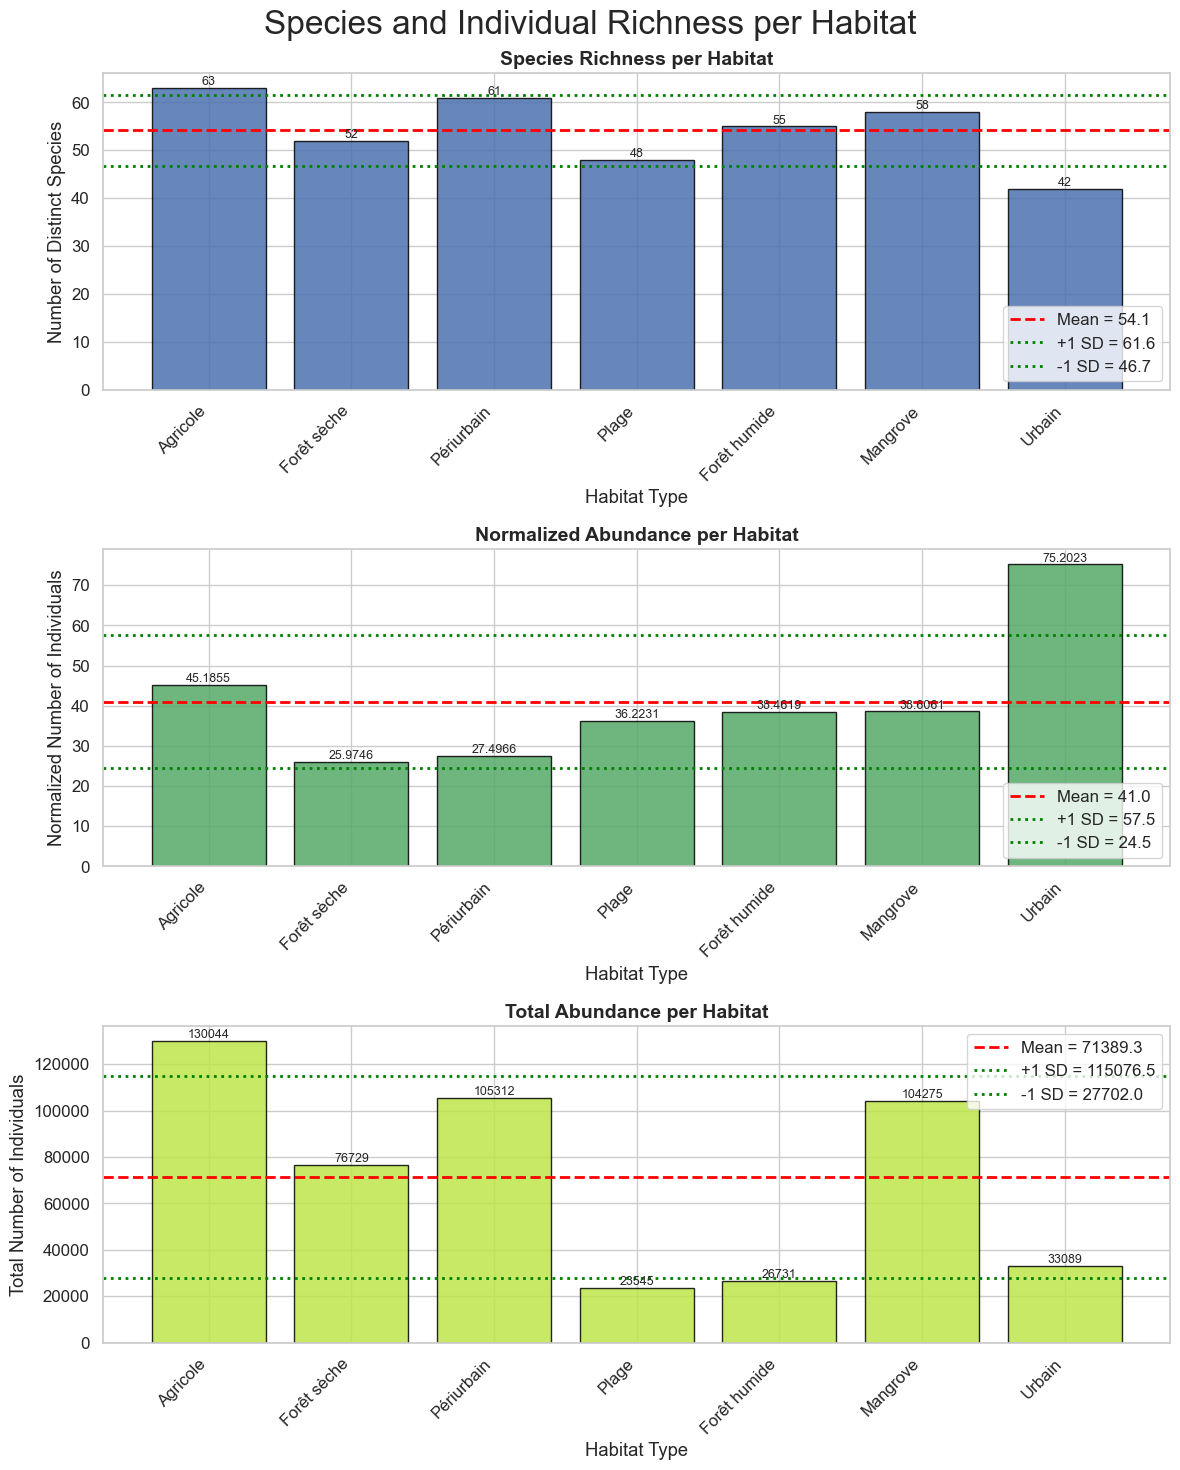

In [2]:
# Global Overview of Species and Individual Richness per Habitat

# Extract the point number (P<number>) from Site+Point in df_sites
df_sites["Point"] = df_sites["Site+Point"].str.extract(r"P(\d+)").astype(int)

# Match observations to sites by Transect and Point number
df_observations = df_observations.rename(columns={"Nom transect": "Transect", "N° point": "Point"})

# Merge observations with site info to attach habitat type
df_obs_sites = pd.merge(df_observations, df_sites[["Transect", "Point", "Type"]], on=["Transect", "Point"], how="left")

# Group by habitat
grouped = df_obs_sites.groupby("Type")

# Species richness = number of distinct species per habitat
species_richness = grouped["clean_espece"].nunique().sort_values(ascending=False)

# Total abundance = total number of individuals (Amount) per habitat
total_abundance = grouped["Amount"].sum().sort_values(ascending=False)

indicator1_df = pd.DataFrame({"Species richness": species_richness, "Total abundance": total_abundance}).reset_index()

# Unique visits = distinct combinations of observer, date, transect, point, and habitat type
unique_visits = (df_obs_sites[["Nom observateur", "date", "Transect", "Point", "Type"]].drop_duplicates())
visits_per_habitat = (unique_visits.groupby("Type").size().rename("Sampling_effort").reset_index())

indicator1_df = indicator1_df.merge(visits_per_habitat, on="Type", how="left")
indicator1_df["Normalized abundance"] = (indicator1_df["Total abundance"] / indicator1_df["Sampling_effort"])

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle("Species and Individual Richness per Habitat", fontsize=24)
order = indicator1_df.sort_values("Species richness", ascending=False)["Type"]

# Barplot for species richness
axes[0].bar(indicator1_df["Type"], indicator1_df["Species richness"], color="#4C72B0", alpha=0.85, edgecolor="black")
mean = indicator1_df["Species richness"].mean()
std = indicator1_df["Species richness"].std()
axes[0].axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.1f}')
axes[0].axhline(mean + std, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean+std:.1f}')
axes[0].axhline(mean - std, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean-std:.1f}')
axes[0].set_title("Species Richness per Habitat", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Habitat Type")
axes[0].set_ylabel("Number of Distinct Species")
axes[0].set_xticklabels(order, rotation=45, ha="right")
axes[0].bar_label(axes[0].containers[0], fontsize=9)
axes[0].legend(loc="lower right", frameon=True)

# Barplot for normalized abundance
axes[1].bar(indicator1_df["Type"], indicator1_df["Normalized abundance"], color="#55A868", alpha=0.85, edgecolor="black")
mean = indicator1_df["Normalized abundance"].mean()
std = indicator1_df["Normalized abundance"].std()
axes[1].axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.1f}')
axes[1].axhline(mean + std, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean+std:.1f}')
axes[1].axhline(mean - std, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean-std:.1f}')
axes[1].set_title("Normalized Abundance per Habitat", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Habitat Type")
axes[1].set_ylabel("Normalized Number of Individuals")
axes[1].set_xticklabels(order, rotation=45, ha="right")
axes[1].bar_label(axes[1].containers[0], fontsize=9)
axes[1].legend(loc="lower right", frameon=True)

# Barplot for total abundance
axes[2].bar(indicator1_df["Type"], indicator1_df["Total abundance"], color="#BDE64A", alpha=0.85, edgecolor="black")
mean = indicator1_df["Total abundance"].mean()
std = indicator1_df["Total abundance"].std()
axes[2].axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.1f}')
axes[2].axhline(mean + std, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean+std:.1f}')
axes[2].axhline(mean - std, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean-std:.1f}')
axes[2].set_title("Total Abundance per Habitat", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Habitat Type")
axes[2].set_ylabel("Total Number of Individuals")
axes[2].set_xticklabels(order, rotation=45, ha="right")
axes[2].bar_label(axes[2].containers[0], fontsize=9)
axes[2].legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.savefig("figures/species_and_individual_richness_per_habitat.jpeg")
plt.show()

In [3]:
# Check unmatched observations
unmatched = df_obs_sites["Type"].isna().sum()
print(f"Unmatched observations (no habitat found): {unmatched}")

if unmatched > 0:
    # Observations with no matching site
    unmatched_rows = df_obs_sites[df_obs_sites["Type"].isna()][["Transect", "Point"]]

    # Unique pairs causing mismatches
    print("Unique (Transect, Point) pairs not found in df_sites:")
    display(unmatched_rows.drop_duplicates().sort_values(["Transect", "Point"]))

    # Compare which Transect values exist in observations but not in sites
    transect_obs = set(df_observations["Transect"].unique())
    transect_sites = set(df_sites["Transect"].unique())
    missing_transects = list(transect_obs - transect_sites)
    if missing_transects:
        print("Transect names present in observations but missing in df_sites:")
        for t in missing_transects:
            print("  -", t)
    else:
        print("All transect names exist in df_sites (the issue is likely with point numbers)")


Unmatched observations (no habitat found): 0


### Indicator 1 CI and trends

To quantify the uncertainty of our indicators, we rely on a non-parametric bootstrap resampling procedure. Ecological monitoring datasets are often unbalanced, noisy, and do not follow classical statistical distributions (species counts are discrete, skewed, and may vary strongly between transects). Standard parametric confidence intervals assume normality and homogeneous variance, which are unrealistic in this context. The bootstrap avoids these assumptions by resampling the original transects with replacement, generating an empirical distribution of the indicator values. From this distribution, we derive confidence intervals without imposing any predefined probability model. For abundance, this is appropriate because birds can be detected multiple times or, conversely, may be undetected. Bootstrapping produces a symmetric confidence interval representing how the measured abundance would fluctuate if the survey were repeated under similar conditions.

For species richness, the interpretation is fundamentally different from abundance. The number of species observed (S_obs) is a confirmed minimum, not an estimate of the true richness. But some species present at a site may simply remain undetected during surveys. Using a symmetric bootstrap interval around the observed value would be inappropriate, since the lower bound cannot fall below the set of species that were actually detected. To account for undetected species, we use the Chao2 estimator, which infers the number of missed species by analyzing the frequency of rare species in the sample (specifically, species observed in only one transect (singletons, Q1) or two transects (doubletons, Q2)). The logic is intuitive: if many species appear in only one or two transects, it suggests that additional rare species likely exist but were not encountered during sampling.

However, the Chao2 estimator can become unstable when sampling coverage is low, potentially producing unrealistically high estimates. To address this, we apply two safeguards:
1. An absolute cap at 87 species (the total number of species in the regional pool)
2. Conservative adjustments when the singleton/doubleton ratio indicates poor coverage

To quantify uncertainty, we bootstrap the Chao2 estimator by resampling transects with replacement and extract the 97.5th percentile of the resulting distribution (chao2_high). This yields an asymmetric confidence interval: **[S_obs, min(chao2_high, 87)]**

This approach acknowledges both data uncertainty and imperfect detection, providing a more realistic interval within which the true biodiversity level lies. We discuss outliers and weird CI in the report.


In [ ]:
# Abundance two-sided bootstrap
def bootstrap_abundance(group, n_boot=1000, rng=None):
    if rng is None: rng = np.random.default_rng()
    transects = group["Transect"].unique()
    obs_val = float(group["Amount"].sum())
    if len(transects) <= 1:
        return obs_val, obs_val, obs_val

    by_tr = {t: group[group["Transect"] == t] for t in transects}
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(transects), size=len(transects))
        vals.append(sum(by_tr[transects[j]]["Amount"].sum() for j in idx))
    low, high = np.percentile(vals, [2.5, 97.5])
    return obs_val, float(low), float(high)

# Bootstrap for Normalized Abundance
def bootstrap_normalized_abundance(group, n_boot=1000, rng=None):
    if rng is None: rng = np.random.default_rng()
    amount_per_tr = group.groupby("Transect")["Amount"].sum()
    transects = group["Transect"].unique()
    visits_df = group[["Transect","Nom observateur","date","Point"]].drop_duplicates()  # Keep unique visits of points
    visits_per_tr = visits_df.groupby("Transect").size()
    obs_abundance = float(amount_per_tr.sum())
    obs_visits = int(visits_per_tr.sum())
    obs_norm = obs_abundance / obs_visits if obs_visits > 0 else np.nan
    if len(transects) <= 1:
        return obs_norm, obs_norm, obs_norm

    vals = []
    tr_list = np.array(transects)
    for _ in range(n_boot):
        idx = rng.integers(0, len(transects), size=len(transects))
        sampled = tr_list[idx]
        boot_abundance = float(sum(amount_per_tr[t] for t in sampled))
        boot_visits = int(sum(visits_per_tr[t] for t in sampled))
        # boot_visits doit être > 0 si les données sont valides
        vals.append(boot_abundance / boot_visits if boot_visits > 0 else np.nan)

    vals = np.asarray(vals, dtype=float)
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        return obs_norm, obs_norm, obs_norm

    low, high = np.percentile(vals, [2.5, 97.5])
    return float(obs_norm), float(low), float(high)

def chao2_estimator(group, max_species=87):
    """
    Chao2 species richness estimator for incidence data
    """
    inc = group.pivot_table(index="clean_espece", columns="Transect", values="Amount", aggfunc="sum", fill_value=0)
    inc_binary = (inc > 0).astype(int)
    
    S_obs = int(inc_binary.shape[0])
    if S_obs == 0:
        return 0.0, 0, 0
    
    T = inc_binary.shape[1]  # Number of transects
    occ = inc_binary.sum(axis=1).to_numpy()
    
    Q1 = int(np.sum(occ == 1))
    Q2 = int(np.sum(occ == 2))
    Q3 = int(np.sum(occ == 3))
    
    # Q1/Q2 ratio
    ratio = Q1 / Q2 if Q2 > 0 else float('inf')
    coverage = 1 - (Q1 / (2 * Q2)) if Q2 > 0 else 0
    
    # Case 1: Excellent coverage (few singletons)
    if coverage > 0.95 or ratio < 2:
        # Reliable classic Chao2
        if Q2 > 0:
            S_hat = S_obs + ((T - 1) / T) * (Q1 * Q1) / (2.0 * Q2)
        else:
            S_hat = S_obs + ((T - 1) / T) * (Q1 * (Q1 - 1)) / 2.0

    # Case 2: Average coverage (moderate ratio)
    elif 2 <= ratio <= 5 and Q2 > 0:
        # iChao2 (uses Q3 to stabilize)
        if Q3 > 0:
            S_hat = S_obs + (Q1 / T) * ((T - 1) * Q1 / (2 * Q2 + Q3/max(1, Q2)))
        else:
            S_hat = S_obs + ((T - 1) / T) * (Q1 * Q1) / (2.5 * Q2)  # Divisor increased

    # Case 3: Low coverage (high ratio) -> CONSERVATIVE
    elif 5 < ratio <= 10:
        # Very conservative method: ACE-like
        # Estimates only a fraction of the missing species
        if Q2 > 0:
            # Divide by a larger factor to be conservative
            S_hat = S_obs + (Q1 * Q1) / (5.0 * Q2)
        else:
            S_hat = S_obs + Q1 / 3.0  # Very conservative

    # Case 4: Very low coverage (ratio > 10) -> ULTRA CONSERVATIVE
    else:
        # Adds only a small fraction
        if Q2 > 0:
            S_hat = S_obs + (Q1 * Q1) / (10.0 * Q2)
        else:
            S_hat = S_obs + Q1 / 5.0  # Adds at most 20% of the singletons

    # Absolute cap
    S_hat = min(S_hat, max_species)

    # If even with cap we exceed 1.5× S_obs, it's suspicious
    if S_hat > 1.8 * S_obs:
        S_hat = min(S_hat, S_obs * 1.8)  # Relative cap
    
    return float(S_hat), Q1, Q2

def bootstrap_richness_incidence(group, n_boot=1000, rng=None):
    """
    Bootstrap by resampling transects with replacement
    """
    if rng is None: rng = np.random.default_rng()
    transects = group["Transect"].unique()
    S_obs = int(group["clean_espece"].nunique())

    # Point estimates on full data
    chao2_hat, _, _ = chao2_estimator(group)

    if len(transects) <= 1 or S_obs == 0:
        return (float(S_obs), float(chao2_hat), float(S_obs), float(chao2_hat))

    by_tr = {t: group[group["Transect"] == t] for t in transects}
    ch_vals = []

    for _ in range(n_boot):
        idx = rng.integers(0, len(transects), size=len(transects))
        sampled = pd.concat([by_tr[transects[j]] for j in idx], ignore_index=True)

        ch_b, _, _ = chao2_estimator(sampled)
        ch_vals.append(ch_b)

    ch_low, ch_high = np.percentile(ch_vals, [2.5, 97.5])

    # Never report a lower bound below what was actually observed
    ch_low = max(S_obs, float(ch_low))

    return (float(S_obs), float(chao2_hat), ch_low, float(ch_high))

# Compute CI
rows = []
rng = np.random.default_rng(42)

for (year, habitat), g in df_obs_sites.groupby(["year", "Type"]):
    A_obs, A_low, A_high = bootstrap_abundance(g, n_boot=1000, rng=rng)
    Norm_obs, Norm_low, Norm_high = bootstrap_normalized_abundance(g, n_boot=1000, rng=rng)
    S_obs, ch_hat, ch_low, ch_high = bootstrap_richness_incidence(g, n_boot=1000, rng=rng)

    rows.append({
        "year": year, "Habitat": habitat,
        "Abundance": A_obs, "Abundance_CI_low": A_low, "Abundance_CI_high": A_high,
        "Normalized_abundance": Norm_obs, "Normalized_abundance_CI_low": Norm_low, "Normalized_abundance_CI_high": Norm_high,
        "Richness_observed": S_obs,
        "Richness_Chao2": ch_hat if ch_hat <= 87 else 87, "Richness_Chao2_CI_low": ch_low, "Richness_Chao2_CI_high": ch_high,
    })

indicator1_multi = pd.DataFrame(rows)

In [5]:
display(indicator1_multi)

,year,Habitat,Abundance,Abundance_CI_low,Abundance_CI_high,Normalized_abundance,Normalized_abundance_CI_low,Normalized_abundance_CI_high,Richness_observed,Richness_Chao2,Richness_Chao2_CI_low,Richness_Chao2_CI_high
0,2014,Agricole,5986.0,4159.775,7824.000,42.757143,33.035536,51.481362,43.0,56.443182,43.0,59.618182
1,2014,Forêt humide,4032.0,3557.875,4660.075,23.857988,19.981762,28.305406,35.0,39.571429,35.0,43.142857
2,2014,Forêt sèche,4497.0,3491.400,5444.450,20.440909,16.876900,24.030674,36.0,46.784314,36.0,54.200000
3,2014,Mangrove,531.0,531.000,531.000,26.550000,26.550000,26.550000,27.0,32.400000,27.0,32.400000
4,2014,Plage,1882.0,1386.000,2334.000,31.366667,23.100000,38.900000,29.0,33.500000,29.0,33.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
79,2025,Forêt sèche,10785.0,8567.875,13135.750,29.875346,23.755796,38.333339,44.0,53.027864,44.0,62.127841
80,2025,Mangrove,1814.0,1416.000,2058.000,30.233333,23.600000,34.300000,32.0,36.500000,32.0,36.500000
81,2025,Plage,1808.0,1368.000,2280.000,30.133333,22.800000,38.000000,33.0,42.657143,33.0,42.657143
82,2025,Périurbain,8573.0,7688.900,9508.250,35.720833,32.594062,39.534687,40.0,53.444444,40.0,56.900000


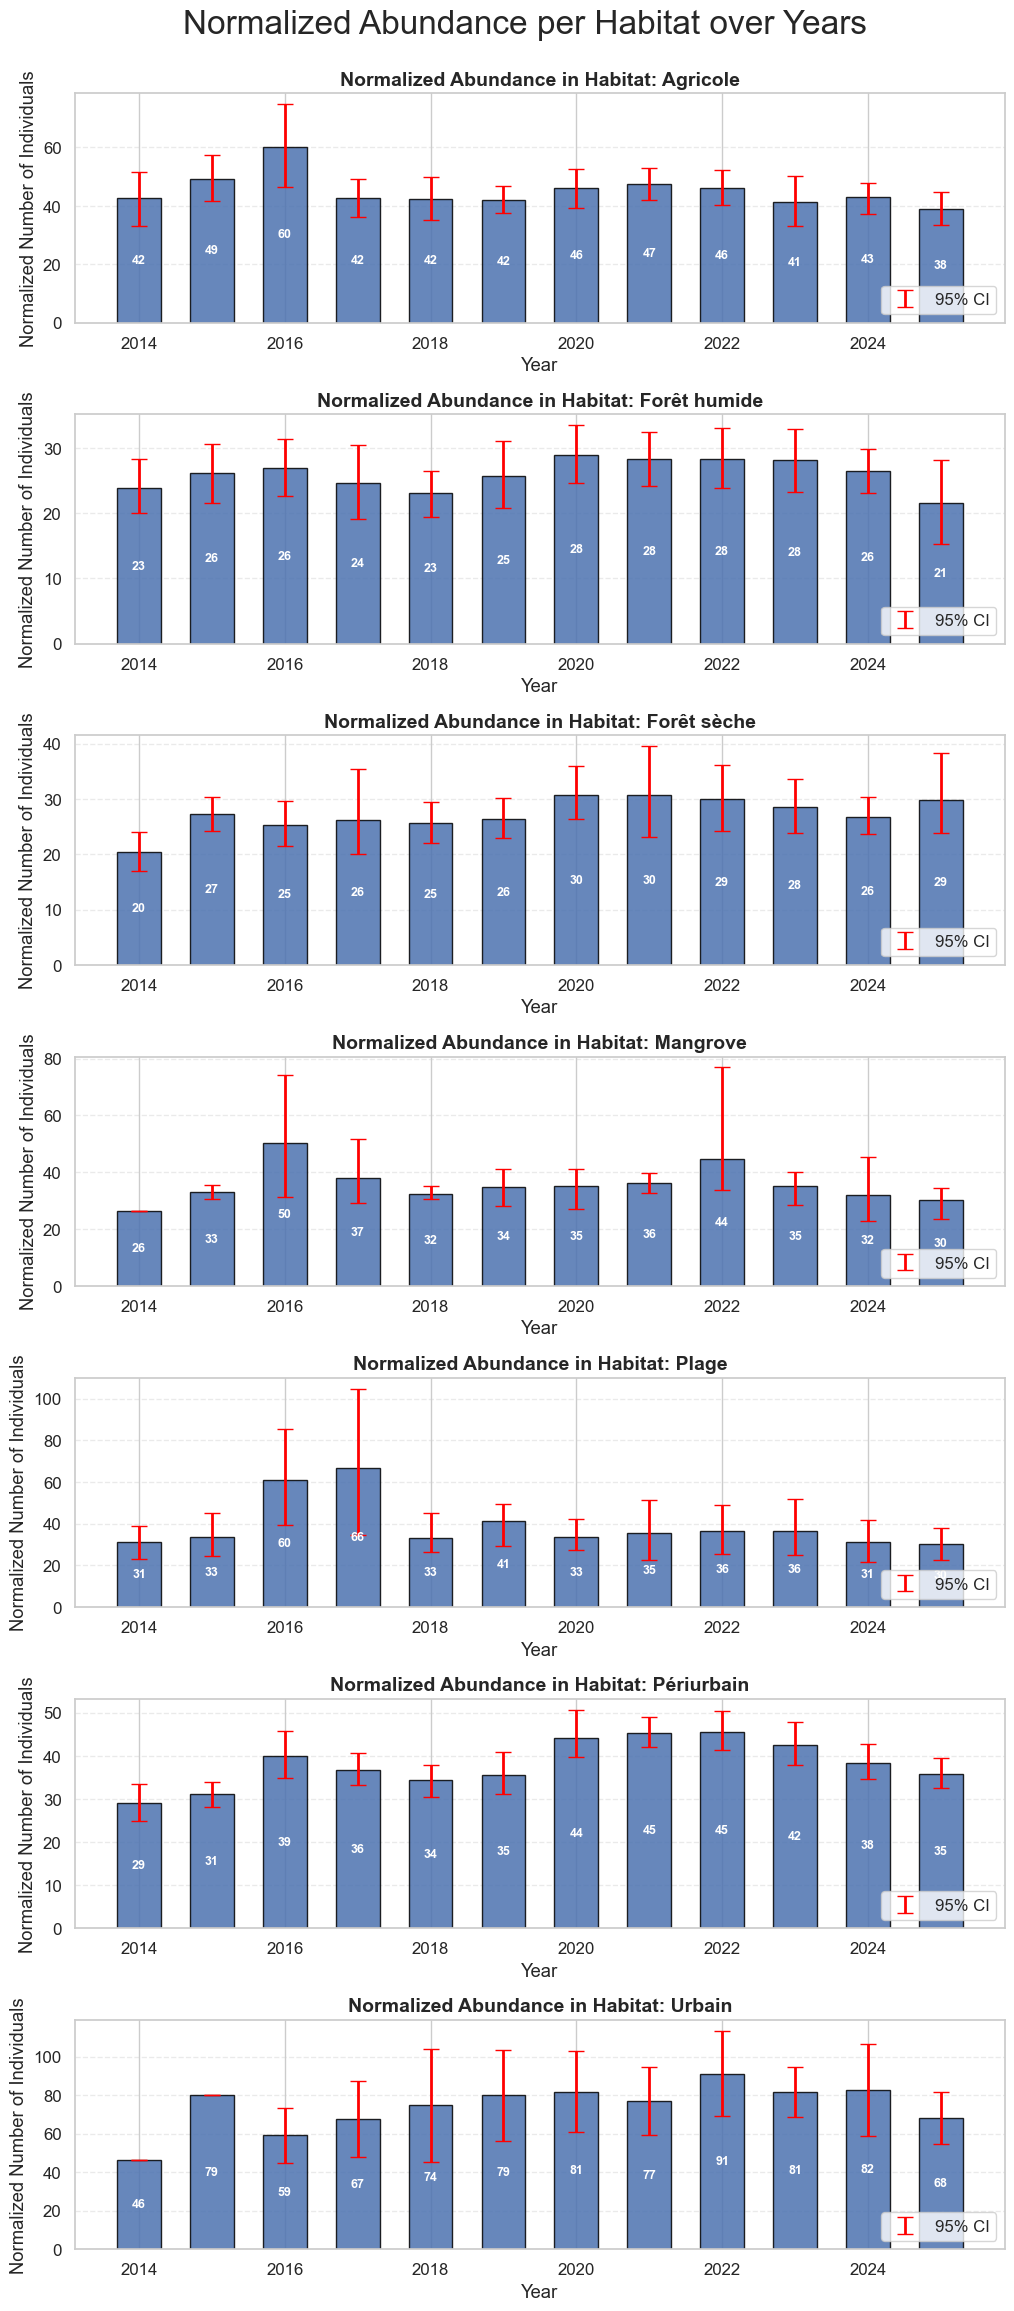

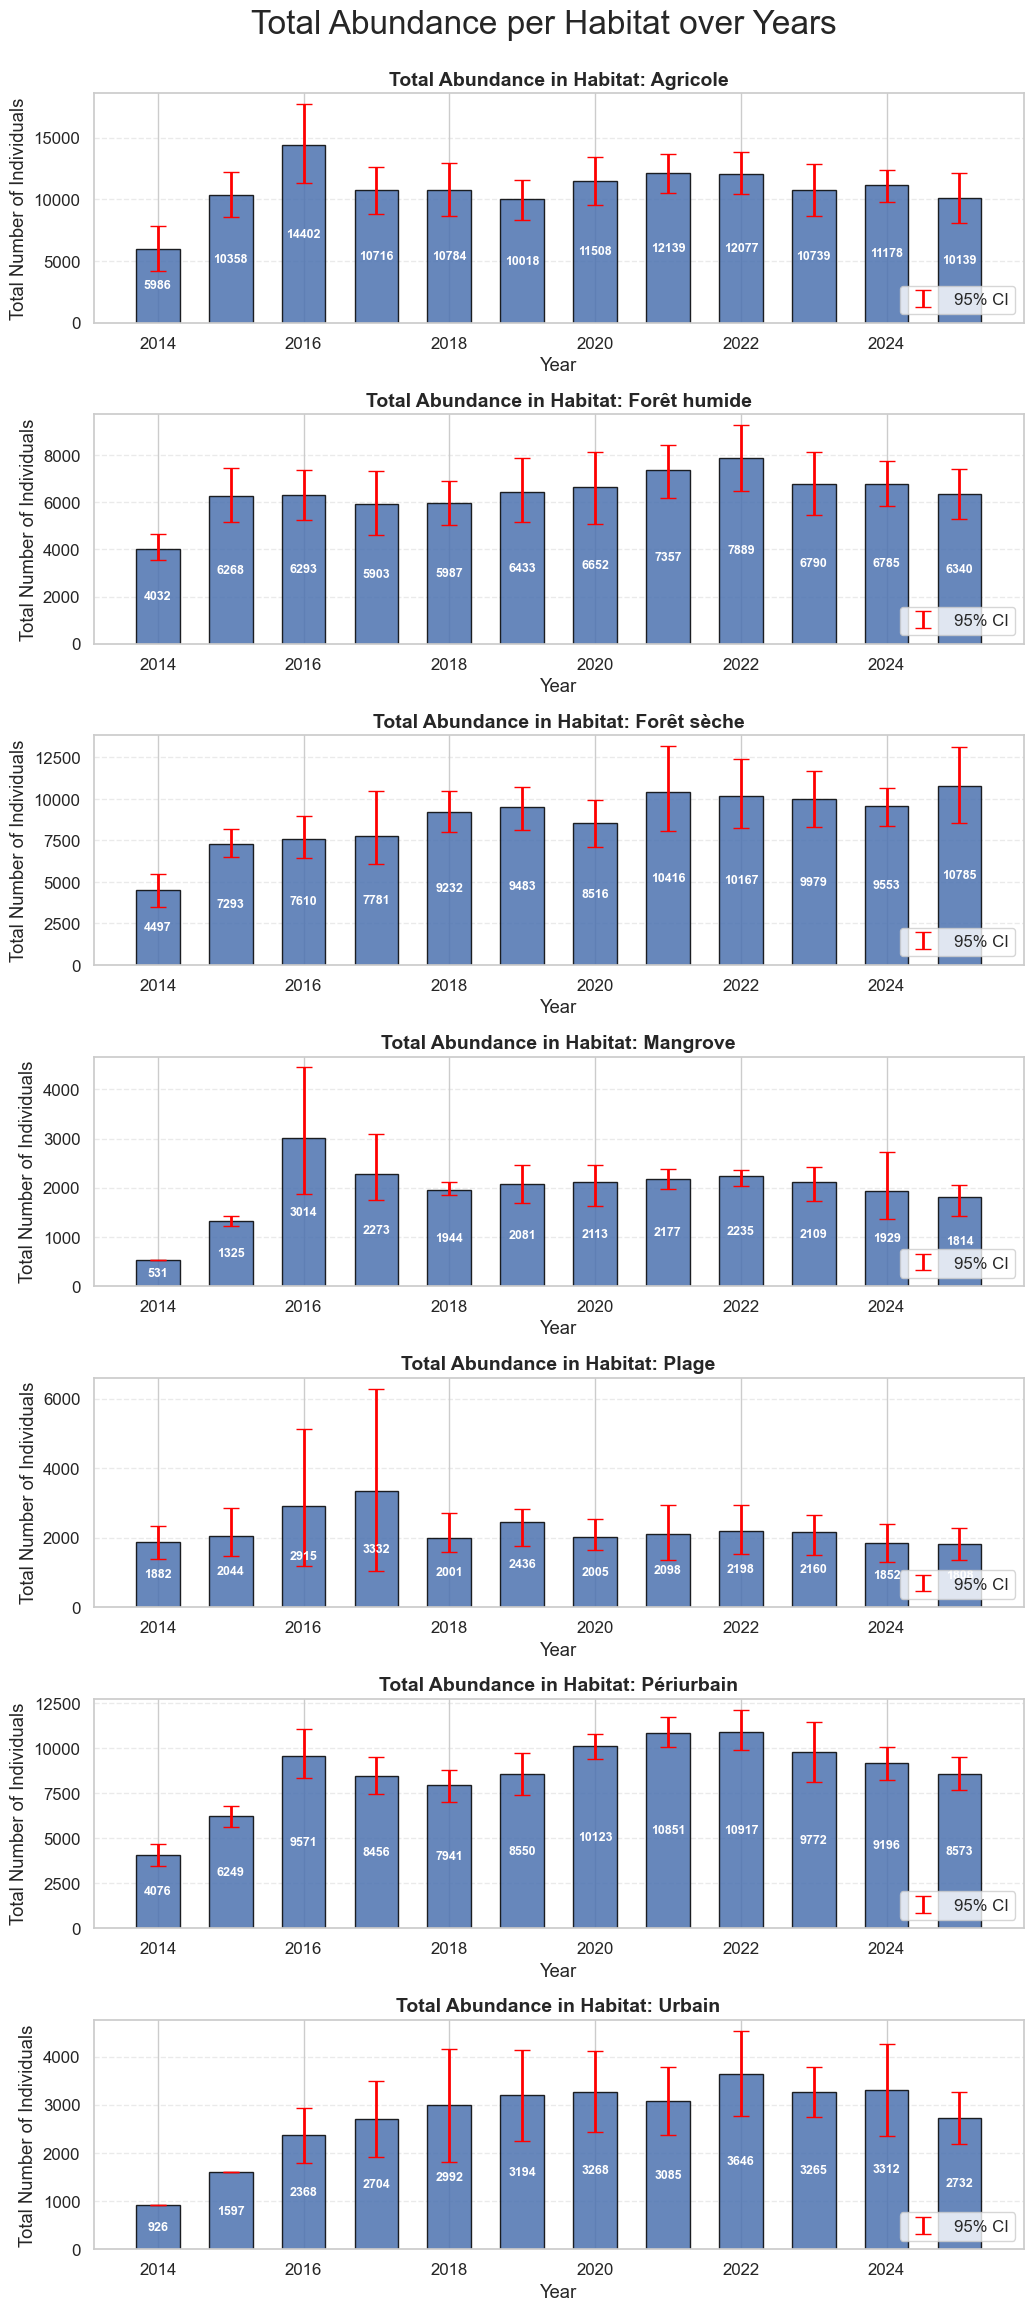

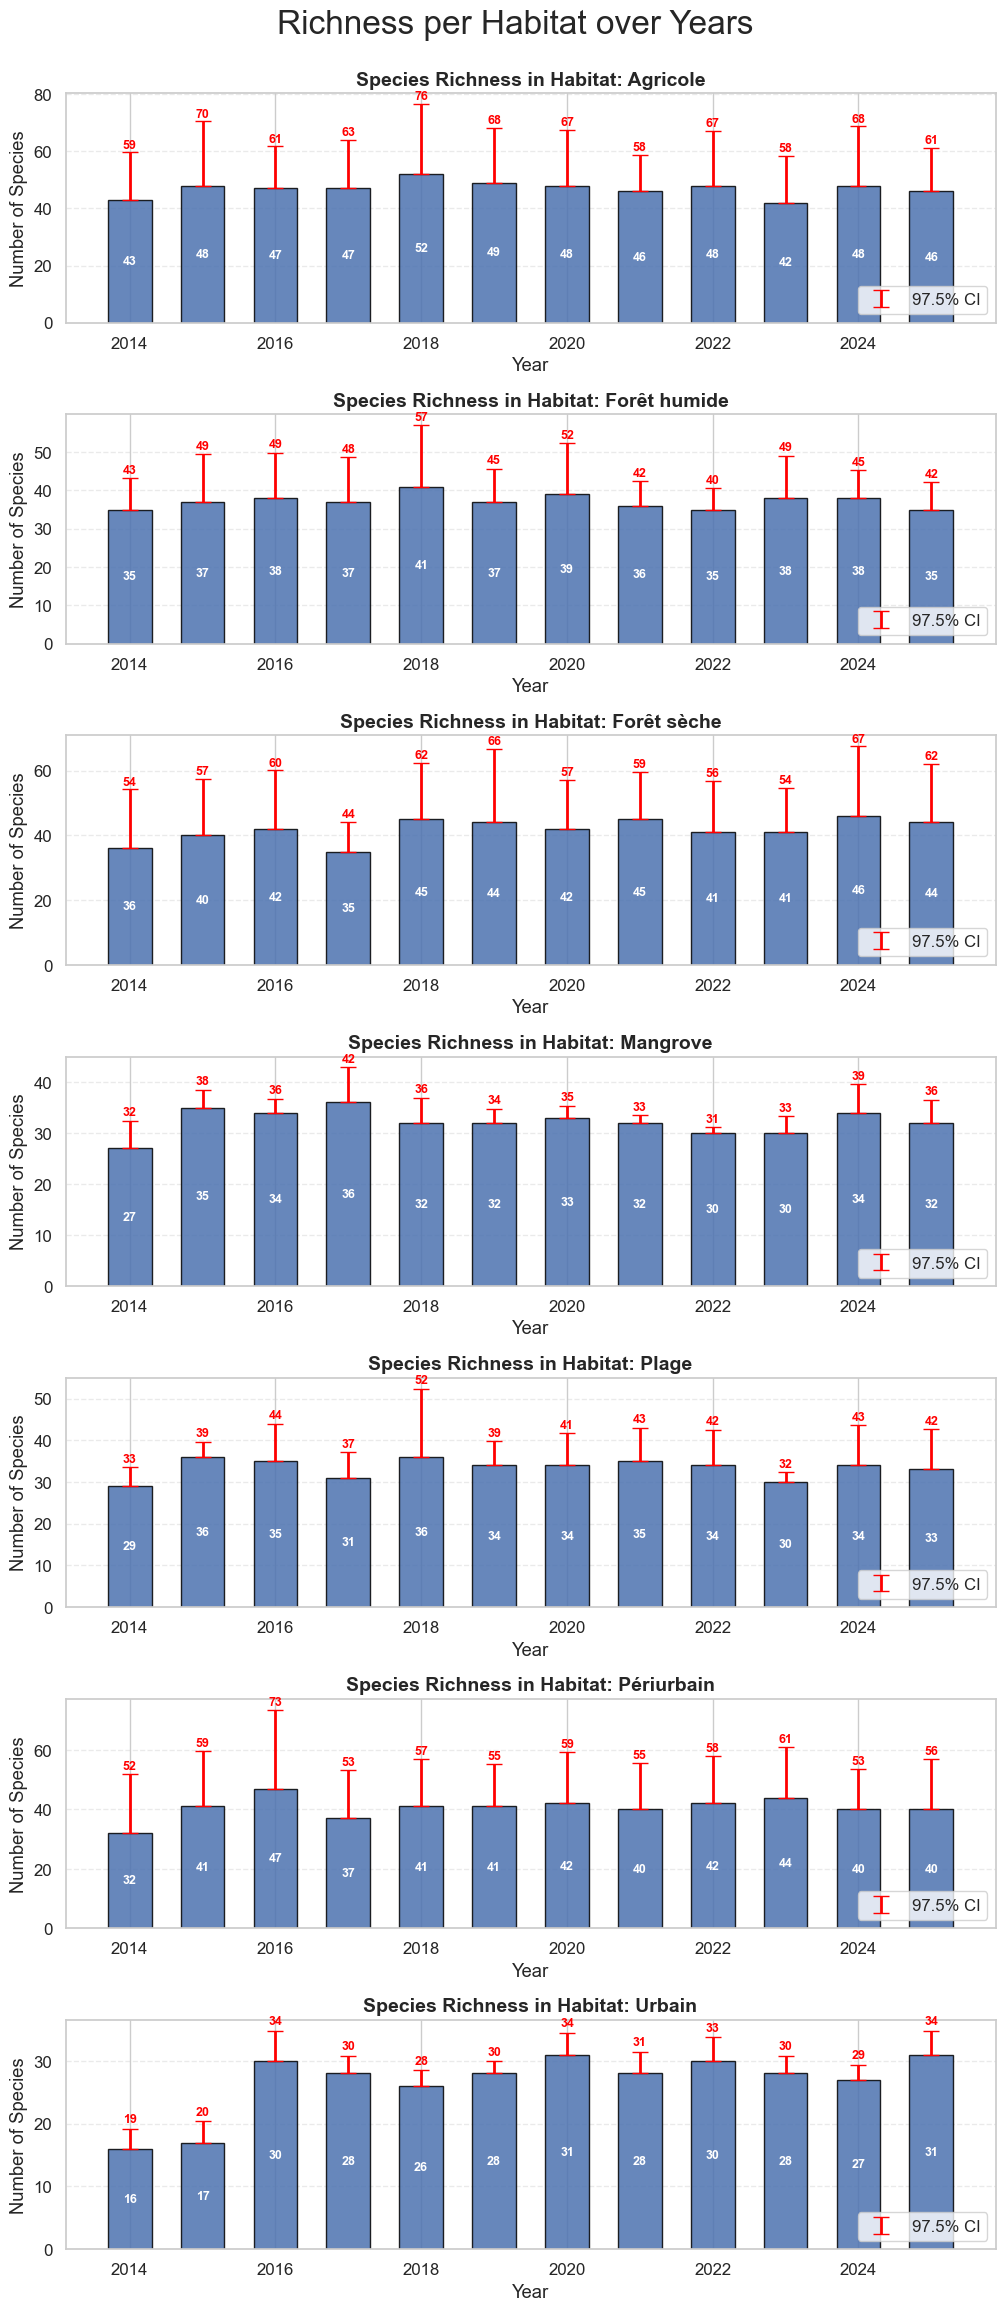

In [6]:
# Plotting Richness and Abundance over Years by Habitat
habitats = indicator1_multi["Habitat"].unique()
n_habitats = len(habitats)

# Normalized Abundance
fig, axes = plt.subplots(nrows=n_habitats, ncols=1, figsize=(12, 4 * n_habitats))
fig.suptitle("Normalized Abundance per Habitat over Years", fontsize=24, y=0.91)  # évite chevauchement

for ax, habitat in zip(axes, habitats):
    g = indicator1_multi[indicator1_multi["Habitat"] == habitat].sort_values("year")
    bars = ax.bar(g["year"], g["Normalized_abundance"], color="#4C72B0", alpha=0.85, width=0.6, edgecolor="black")
    ax.errorbar(g["year"], g["Normalized_abundance"], yerr=[g["Normalized_abundance"] - g["Normalized_abundance_CI_low"], g["Normalized_abundance_CI_high"] - g["Normalized_abundance"]], fmt="none", ecolor="red", elinewidth=2, capsize=6, label="95% CI")
    for bar, value in zip(bars, g["Normalized_abundance"]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2, f"{int(value)}", ha="center", va="center", fontsize=9, fontweight="bold", color="white")
    ax.set_title(f"Normalized Abundance in Habitat: {habitat}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Normalized Number of Individuals")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc="lower right", frameon=True)

plt.xlabel("Year")
plt.subplots_adjust(hspace=0.4)
plt.savefig("figures/multi_year_normalized_abundance_by_habitat.jpeg", dpi=300, bbox_inches="tight")
plt.show()

# Total Abundance
fig, axes = plt.subplots(nrows=n_habitats, ncols=1, figsize=(12, 4 * n_habitats))
fig.suptitle("Total Abundance per Habitat over Years", fontsize=24, y=0.91) 

for ax, habitat in zip(axes, habitats):
    g = indicator1_multi[indicator1_multi["Habitat"] == habitat].sort_values("year")
    bars = ax.bar(g["year"], g["Abundance"], color="#4C72B0", alpha=0.85, width=0.6, edgecolor="black")
    ax.errorbar(g["year"], g["Abundance"], yerr=[g["Abundance"] - g["Abundance_CI_low"], g["Abundance_CI_high"] - g["Abundance"]], fmt="none", ecolor="red", elinewidth=2, capsize=6, label="95% CI")
    for bar, value in zip(bars, g["Abundance"]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2, f"{int(value)}", ha="center", va="center", fontsize=9, fontweight="bold", color="white")
    ax.set_title(f"Total Abundance in Habitat: {habitat}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Number of Individuals")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc="lower right", frameon=True)

plt.xlabel("Year")
plt.subplots_adjust(hspace=0.4)
plt.savefig("figures/multi_year_total_abundance_by_habitat.jpeg", dpi=300, bbox_inches="tight")
plt.show()

# Richness (Observed + Chao2 Upper Bound)
fig, axes = plt.subplots(nrows=n_habitats, ncols=1, figsize=(12, 4 * n_habitats))
fig.suptitle("Richness per Habitat over Years", fontsize=24, y=0.91)

for ax, habitat in zip(axes, habitats):
    g = indicator1_multi[indicator1_multi["Habitat"] == habitat].sort_values("year")
    bars = ax.bar(g["year"], g["Richness_observed"], color="#4C72B0", alpha=0.85, width=0.6, edgecolor="black")
    ax.errorbar(g["year"], g["Richness_observed"], yerr=[np.zeros(len(g)), g["Richness_Chao2_CI_high"] - g["Richness_observed"]], fmt="none", ecolor="red", elinewidth=2, capsize=6, label="97.5% CI")
    for bar, value in zip(bars, g["Richness_observed"]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2, f"{int(value)}", ha="center", va="center", fontsize=9, fontweight="bold", color="white")
    for x, ub in zip(g["year"], g["Richness_Chao2_CI_high"]):
        ax.text(x, ub + 0.5, f"{int(ub)}", ha="center", va="bottom", fontsize=9, fontweight="bold", color="red")
    ax.set_title(f"Species Richness in Habitat: {habitat}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Species")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc="lower right", frameon=True)

plt.subplots_adjust(hspace=0.4)
plt.savefig("figures/multi_year_richness_by_habitat.jpeg", dpi=300, bbox_inches="tight")
plt.show()

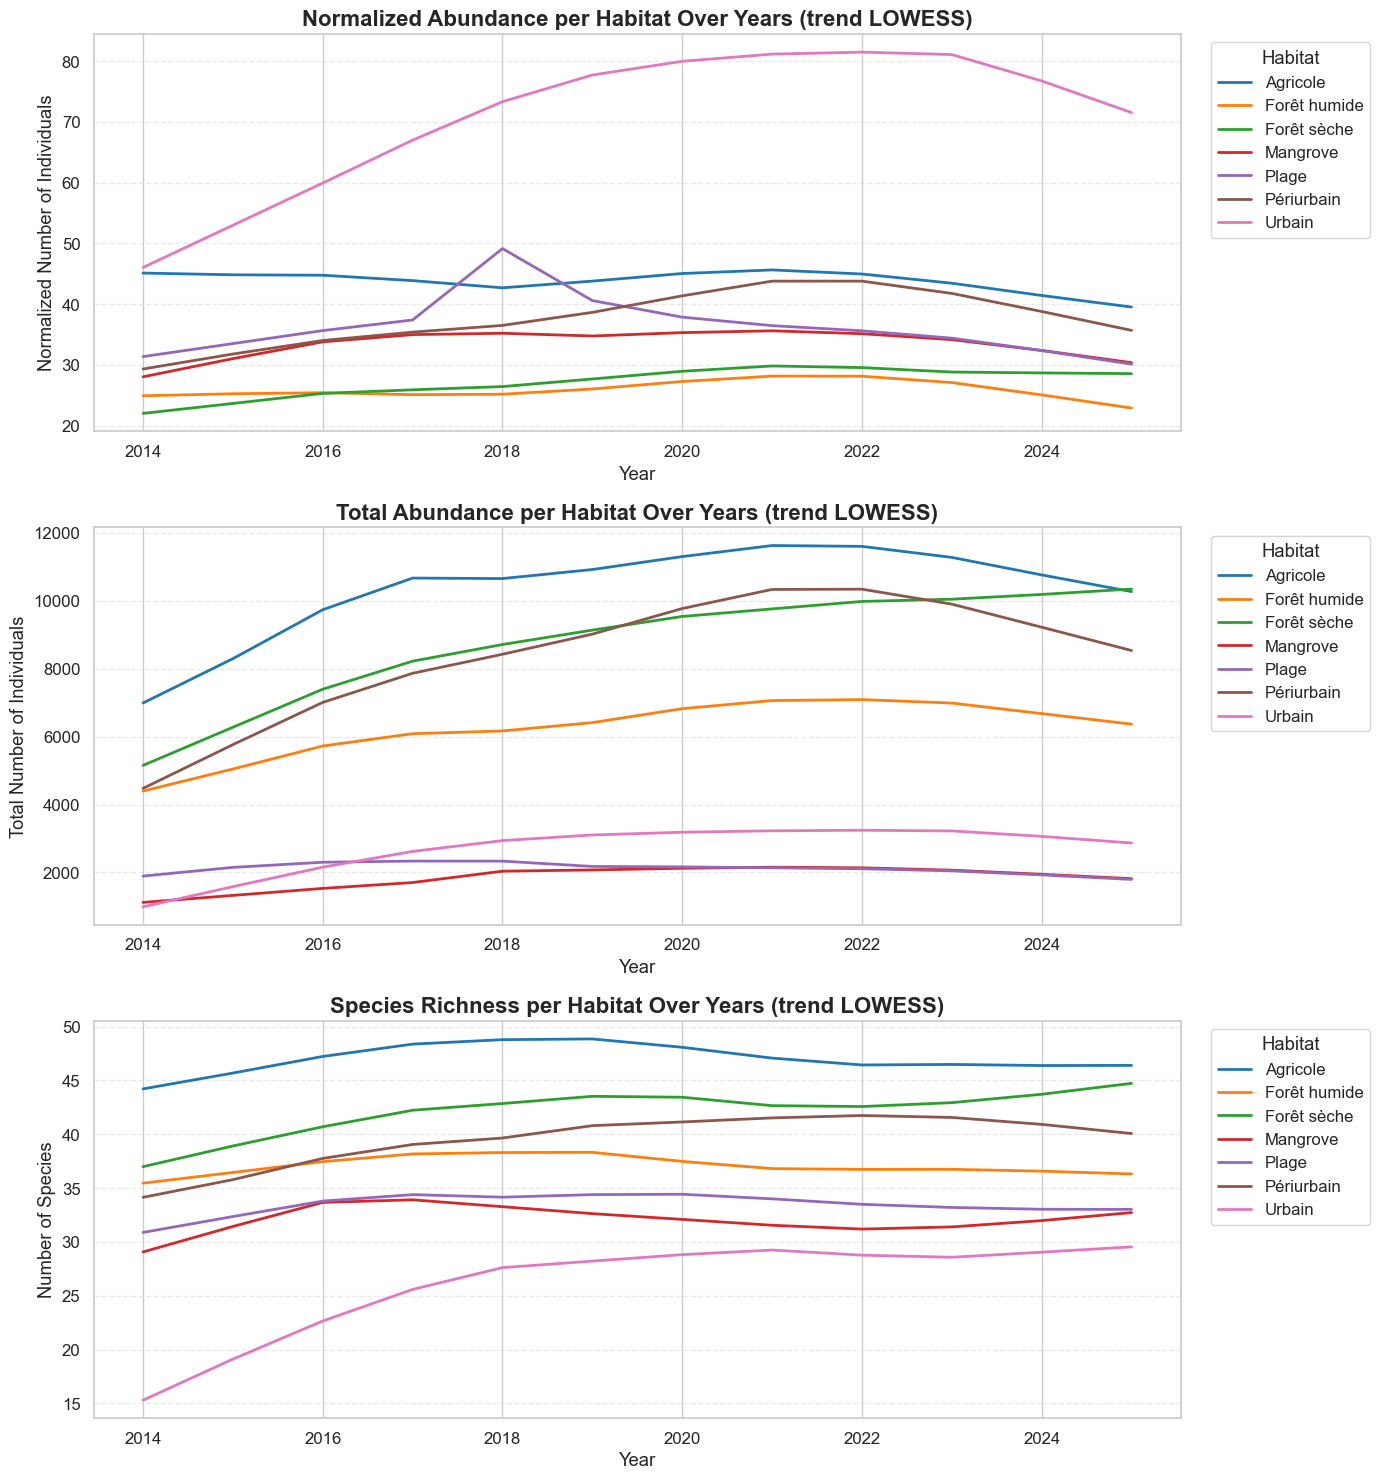

In [7]:
# Habitat trend plots
plt.figure(figsize=(14, 15))
habitats = indicator1_multi["Habitat"].unique()
colors = sns.color_palette("tab10", n_colors=len(habitats))

# Normalized Abundance
ax1 = plt.subplot(3, 1, 1)
for habitat, col in zip(habitats, colors):
    g = indicator1_multi[indicator1_multi["Habitat"] == habitat].sort_values("year")
    trend = lowess(g["Normalized_abundance"], g["year"], frac=0.5)
    ax1.plot(trend[:, 0], trend[:, 1], color=col, linewidth=2, linestyle="-", label=f"{habitat}")
ax1.set_title("Normalized Abundance per Habitat Over Years (trend LOWESS)", fontsize=16, fontweight="bold")
ax1.set_ylabel("Normalized Number of Individuals")
ax1.set_xlabel("Year")
ax1.grid(axis="y", linestyle="--", alpha=0.4)
ax1.legend(title="Habitat", bbox_to_anchor=(1.02, 1), loc="upper left")

# Total Abundance
ax2 = plt.subplot(3, 1, 2)
for habitat, col in zip(habitats, colors):
    g = indicator1_multi[indicator1_multi["Habitat"] == habitat].sort_values("year")
    trend = lowess(g["Abundance"], g["year"], frac=0.5)
    ax2.plot(trend[:, 0], trend[:, 1], color=col, linewidth=2, linestyle="-", label=f"{habitat}")
ax2.set_title("Total Abundance per Habitat Over Years (trend LOWESS)", fontsize=16, fontweight="bold")
ax2.set_ylabel("Total Number of Individuals")
ax2.grid(axis="y", linestyle="--", alpha=0.4)
ax2.set_xlabel("Year")
ax2.legend(title="Habitat", bbox_to_anchor=(1.02, 1), loc="upper left")

# Richness
ax3 = plt.subplot(3, 1, 3)
for habitat, col in zip(habitats, colors):
    g = indicator1_multi[indicator1_multi["Habitat"] == habitat].sort_values("year")
    trend = lowess(g["Richness_observed"], g["year"], frac=0.5)
    ax3.plot(trend[:, 0], trend[:, 1], color=col, linewidth=2, linestyle="-", label=f"{habitat}")
ax3.set_title("Species Richness per Habitat Over Years (trend LOWESS)", fontsize=16, fontweight="bold")
ax3.set_ylabel("Number of Species")
ax3.set_xlabel("Year")
ax3.grid(axis="y", linestyle="--", alpha=0.4)
ax3.legend(title="Habitat", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.savefig("figures/trends_species_and_individual_richness_per_habitat.jpeg", dpi=300)
plt.show()

# Indicator 2: Shannon diversity index and origin proportions per habitat

The second indicator focuses on the composition of habitat according to the biogeographical origin of the species (native, endemic, introduced, migratory, marine, etc.). While species richness provides a measure of diversity, it does not reveal how that diversity is structured. Tracking the proportion of endemic and native species versus introduced or invasive ones offers a much deeper ecological understanding of the state of each habitat. An increase in exotic or invasive species may signal habitat degradation, human pressure, or ecological imbalance, whereas a high proportion of native or endemic species generally reflects good habitat quality and functional integrity. By analyzing how the composition of species changes over time and across habitats, this indicator allows us to detect early warning signals such as biological invasions. It provides actionable information for conservation planning, helping to prioritize habitats where native biodiversity should be protected or restored, and to identify those where management actions may be needed to limit the spread of introduced species.


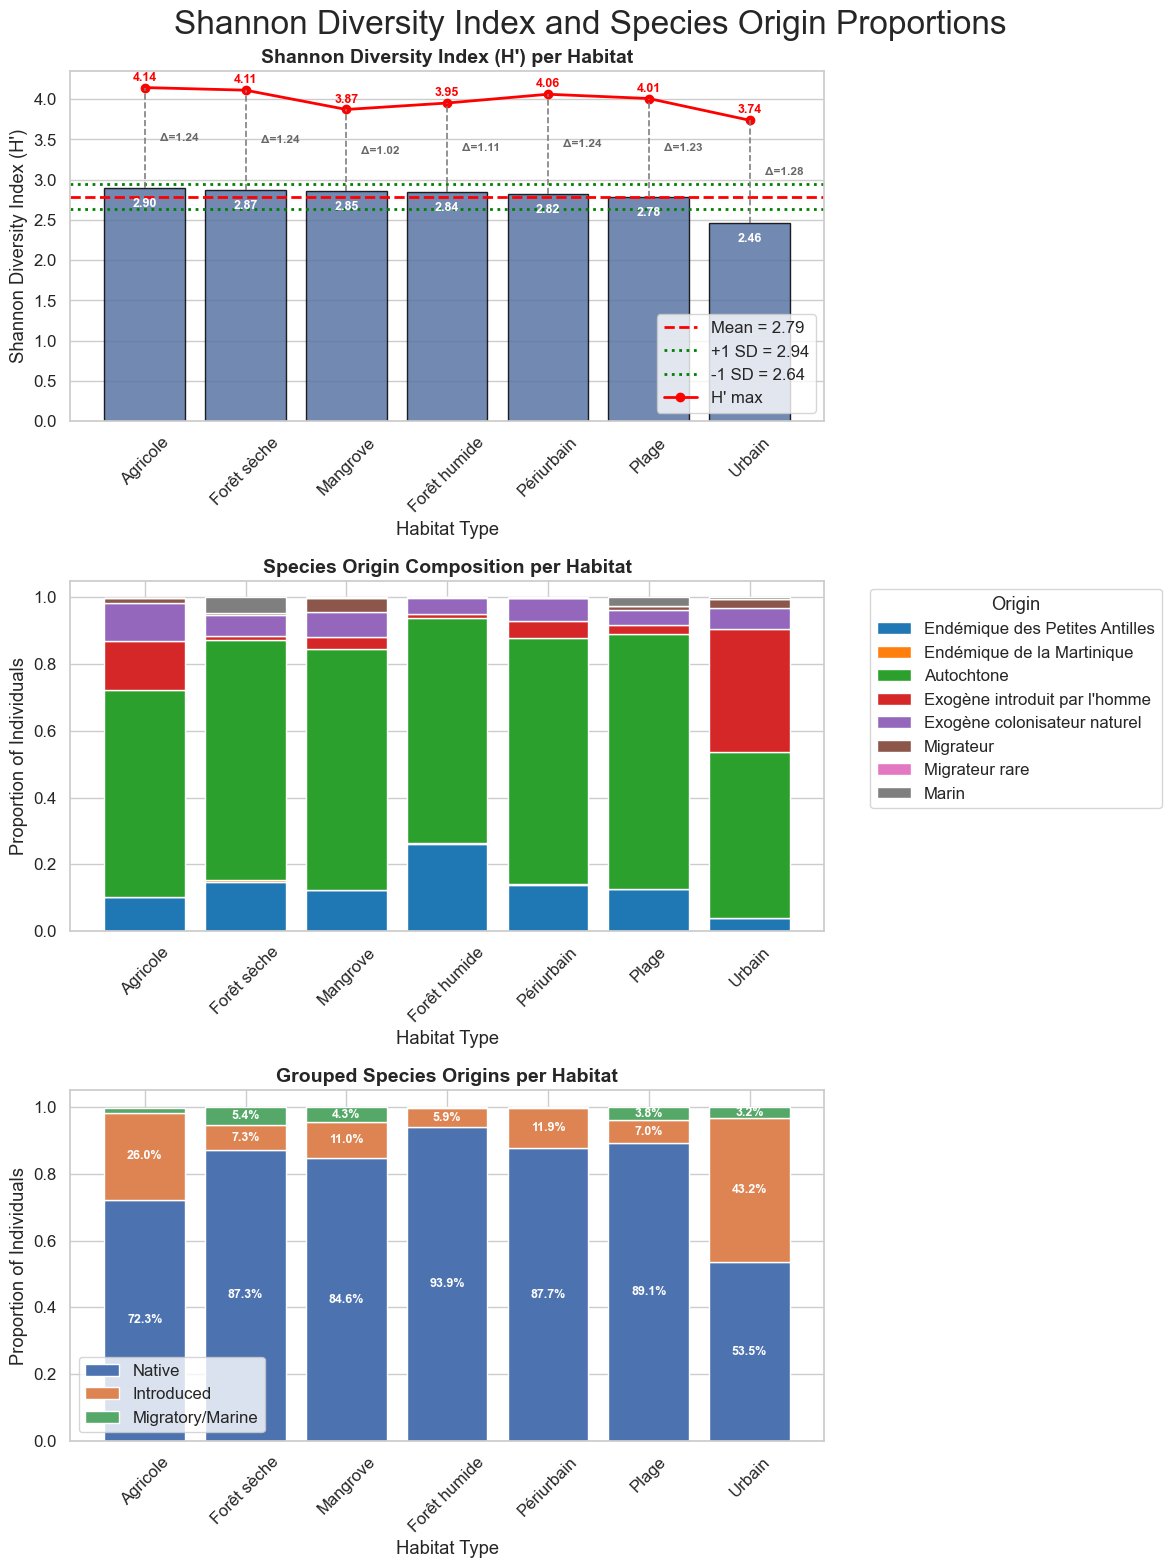

In [8]:
# Global Overview of Shannon Diversity Index and Species Origin Proportions per Habitat

# Merge df_obs_sites with df_species to attach origin information
df_obs_full = pd.merge(df_obs_sites, df_species[["clean_name", "Origin"]], left_on="clean_espece", right_on="clean_name", how="left")

# Function to compute Shannon diversity index
def shannon_index(group):
    """
    Compute the Shannon diversity index for a given group of observations
    """
    counts = group.groupby("clean_espece")["Amount"].sum()
    counts = counts[counts > 0].dropna()
    if counts.empty:
        return 0.0

    p = counts / counts.sum()
    p = p.astype(float).to_numpy()
    p = p[p > 0]
    if len(p) == 0:
        return 0.0

    return float(-np.sum(p * np.log(p)))

# Compute Shannon index and origin proportions per habitat
results = []
for habitat, g in df_obs_full.groupby("Type"):
    if g.empty:
        continue

    H = shannon_index(g)
    total = g["Amount"].sum()

    origin_counts = (
        g.groupby("Origin")["Amount"].sum().reindex([
            "Endémique des Petites Antilles",
            "Endémique de la Martinique",
            "Autochtone",
            "Exogène introduit par l'homme",
            "Exogène colonisateur naturel",
            "Migrateur",
            "Migrateur rare",
            "Marin"
        ], fill_value=0)
    )
    proportions = (origin_counts / total).to_dict()

    results.append({"Habitat": habitat, "Shannon_index": H, **proportions})

indicator2_df = pd.DataFrame(results).fillna(0)

# Compute Hmax = ln(S) correctly
species_richness = (df_obs_full.dropna(subset=["Type", "clean_espece"]).groupby("Type")["clean_espece"].nunique())
hmax_df = pd.DataFrame({"Habitat": species_richness.index, "Hmax": np.log(species_richness.values)})
indicator2_df = indicator2_df.merge(hmax_df, on="Habitat", how="left")
indicator2_df["Hmax"] = indicator2_df["Hmax"].fillna(0)
mean_shannon = indicator2_df["Shannon_index"].mean()
std_shannon = indicator2_df["Shannon_index"].std()

# Sort habitats for plotting
indicator2_df_sorted = indicator2_df.sort_values("Shannon_index", ascending=False)

# Compute grouped origin categories
indicator2_df_grouped = indicator2_df_sorted.copy()
indicator2_df_grouped["Native"] = (
    indicator2_df_grouped["Autochtone"]
    + indicator2_df_grouped["Endémique de la Martinique"]
    + indicator2_df_grouped["Endémique des Petites Antilles"]
)
indicator2_df_grouped["Introduced"] = (
    indicator2_df_grouped["Exogène introduit par l'homme"]
    + indicator2_df_grouped["Exogène colonisateur naturel"]
)
indicator2_df_grouped["Migratory/Marine"] = (
    indicator2_df_grouped["Migrateur"]
    + indicator2_df_grouped["Migrateur rare"]
    + indicator2_df_grouped["Marin"]
)

grouped_cols = ["Native", "Introduced", "Migratory/Marine"]
grouped_colors = ["#4C72B0", "#DD8452", "#55A868"]

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
fig.suptitle("Shannon Diversity Index and Species Origin Proportions", fontsize=24)

# Shannon diversity per habitat
sns.barplot(data=indicator2_df_sorted, x="Habitat", y="Shannon_index", color="#4C72B0", ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].axhline(mean_shannon, color="red", linestyle="--", linewidth=2, label=f'Mean = {mean_shannon:.2f}')
axes[0].axhline(mean_shannon + std_shannon, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean_shannon + std_shannon:.2f}')
axes[0].axhline(mean_shannon - std_shannon, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean_shannon - std_shannon:.2f}')
for i, (hab, h_val) in enumerate(zip(indicator2_df_sorted["Habitat"], indicator2_df_sorted["Shannon_index"])):
    axes[0].text(i, h_val - 0.12, f"{h_val:.2f}", ha="center", va="top", color="white", fontsize=9, fontweight="bold")

# Plot H' max line
axes[0].plot(indicator2_df_sorted["Habitat"], indicator2_df_sorted["Hmax"].values, color="red", linestyle="-", marker="o", markersize=6, linewidth=2, label="H' max")
for i, hmax in enumerate(indicator2_df_sorted["Hmax"]):
    axes[0].text(i, hmax + 0.05, f"{hmax:.2f}", ha="center", va="bottom", fontsize=9, color="red", fontweight="bold")

# Annotate difference
for i, (h_val, hmax) in enumerate(zip(indicator2_df_sorted["Shannon_index"], indicator2_df_sorted["Hmax"])):
    diff = hmax - h_val
    axes[0].plot([i, i], [h_val, hmax], color="gray", linestyle="--", linewidth=1.2)
    axes[0].text(i + 0.15, (h_val + hmax) / 2, f"Δ={diff:.2f}",ha="left", va="center", fontsize=8.5, color="dimgray", fontweight="semibold")

axes[0].set_title("Shannon Diversity Index (H') per Habitat", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Shannon Diversity Index (H')")
axes[0].set_xlabel("Habitat Type")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc="lower right", frameon=True)

# Detailed origin composition per habitat
origins = [
    "Endémique des Petites Antilles", "Endémique de la Martinique",
    "Autochtone", "Exogène introduit par l'homme",
    "Exogène colonisateur naturel", "Migrateur", "Migrateur rare", "Marin"
]
origin_colors = sns.color_palette("tab10", n_colors=len(origins))

bottom = np.zeros(len(indicator2_df_sorted))
for i, origin in enumerate(origins):
    axes[1].bar(indicator2_df_sorted["Habitat"], indicator2_df_sorted[origin], bottom=bottom, label=origin, color=origin_colors[i])
    bottom += indicator2_df_sorted[origin].values

axes[1].set_title("Species Origin Composition per Habitat", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Proportion of Individuals")
axes[1].set_xlabel("Habitat Type")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Origin")

# Grouped origin categories per habitat
bottom = np.zeros(len(indicator2_df_grouped))
bars_dict = {}
for i, cat in enumerate(grouped_cols):
    bars = axes[2].bar(indicator2_df_grouped["Habitat"], indicator2_df_grouped[cat], bottom=bottom, label=cat, color=grouped_colors[i])
    bars_dict[cat] = (bars, bottom.copy())
    bottom += indicator2_df_grouped[cat].values

# Add percentage labels (>2.5%)
for cat, (bars, start) in bars_dict.items():
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.025:
            axes[2].text(bar.get_x() + bar.get_width() / 2, start[j] + height / 2, f"{height*100:.1f}%", ha="center", va="center", fontsize=9, color="white", fontweight="bold")

axes[2].set_title("Grouped Species Origins per Habitat", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Proportion of Individuals")
axes[2].set_xlabel("Habitat Type")
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("figures/shannon_index_and_origin_proportions_per_habitat.jpeg")
plt.show()

In [9]:
# Check if every observation successfully matched with an origin in df_species
unmatched_origin = df_obs_full[df_obs_full["Origin"].isna()]

print(f"Total unmatched observations (no origin found): {len(unmatched_origin)}")

if not unmatched_origin.empty:
    print("Unmatched species (no origin info found):")
    display(unmatched_origin[["clean_espece", "Transect", "Point", "Amount"]].drop_duplicates())
else:
    print("All observations successfully matched with a species origin.")

Total unmatched observations (no origin found): 2
Unmatched species (no origin info found):


,clean_espece,Transect,Point,Amount
5340,ras,pointe banane,9.0,0.0
19222,ras,le phare-caravelle,10.0,0.0


### Indicator 2 CI and trends

The Shannon diversity index and the origin proportions are derived from the relative distribution of individuals among species (Shannon) or among origin categories (Native / Introduced / Migratory). These values are not direct counts but functions of the community structure, which makes classical parametric confidence intervals inappropriate.

To capture uncertainty, we applied a non-parametric bootstrap at the transect level.
At each bootstrap iteration:
1) transects were resampled with replacement within a given habitat and year,
2) the Shannon index was recalculated,
3) the proportions of individuals belonging to each origin category were recomputed.

Repeating this procedure many times yields an empirical distribution of Shannon values and origin proportions. We extracted the 2.5th and 97.5th percentiles of these bootstrap distributions as confidence intervals.

This approach is particularly relevant in ecology because it:
- does not assume any specific distribution of the data (counts of species are discrete, skewed, and non-Gaussian),
- quantifies the uncertainty that would occur if the survey were repeated under similar conditions.

Thus, the bootstrap intervals around Shannon and origin proportions reflect the precision of the estimated community structure, not only the number of individuals detected.

In [10]:
# Bootstrap function for indicator 2
def bootstrap_indicator2(group, n_boot=1000):
    transects = group["Transect"].unique()

    H_values = []
    origins = ["Native", "Introduced", "Migratory/Marine"]
    origin_values = {o: [] for o in origins}

    for _ in range(n_boot):
        sampled = np.random.choice(transects, size=len(transects), replace=True)
        subset = pd.concat([group[group["Transect"] == t] for t in sampled])

        # Shannon bootstrap
        H_values.append(shannon_index(subset))

        # Grouped origin proportions
        freq = subset.groupby("Origin")["Amount"].sum()
        freq = freq / freq.sum()
        origin_values["Native"].append(
        freq.get("Autochtone", 0) + freq.get("Endémique de la Martinique", 0) + freq.get("Endémique des Petites Antilles", 0))
        origin_values["Introduced"].append(freq.get("Exogène introduit par l'homme", 0) + freq.get("Exogène colonisateur naturel", 0))
        origin_values["Migratory/Marine"].append(freq.get("Migrateur", 0) + freq.get("Migrateur rare", 0) + freq.get("Marin", 0))

    # Confidence intervals
    H_low, H_high = np.percentile(H_values, [2.5, 97.5])
    origin_ci = {o: (np.percentile(vals, 2.5), np.percentile(vals, 97.5))
                 for o, vals in origin_values.items()}

    return H_low, H_high, origin_ci


# Compute indicator 2 multi-year
records = []

for (year, habitat), subset in df_obs_full.groupby(["year", "Type"]):

    H_obs = shannon_index(subset)
    H_low, H_high, origin_ci = bootstrap_indicator2(subset, n_boot=1000)

    # Observed proportion
    freq_obs = subset.groupby("Origin")["Amount"].sum()
    freq_obs = freq_obs / freq_obs.sum()

    # Compute grouped origin observed too
    native_obs = (freq_obs.get("Autochtone", 0) + freq_obs.get("Endémique de la Martinique", 0) + freq_obs.get("Endémique des Petites Antilles", 0))
    introduced_obs = (freq_obs.get("Exogène introduit par l'homme", 0)+ freq_obs.get("Exogène colonisateur naturel", 0))
    migratory_obs = (freq_obs.get("Migrateur", 0) + freq_obs.get("Migrateur rare", 0) + freq_obs.get("Marin", 0))

    records.append({
        "year": year,
        "Habitat": habitat,
        "Shannon_obs": H_obs,
        "Shannon_low": H_low,
        "Shannon_high": H_high,
        "Native": native_obs,
        "Native_low": origin_ci["Native"][0],
        "Native_high": origin_ci["Native"][1],
        "Introduced": introduced_obs,
        "Introduced_low": origin_ci["Introduced"][0],
        "Introduced_high": origin_ci["Introduced"][1],
        "Migratory_Marine": migratory_obs,
        "Migratory_low": origin_ci["Migratory/Marine"][0],
        "Migratory_high": origin_ci["Migratory/Marine"][1],
    })

indicator2_multi = pd.DataFrame(records)

In [11]:
display(indicator2_multi)

,year,Habitat,Shannon_obs,Shannon_low,Shannon_high,Native,Native_low,Native_high,Introduced,Introduced_low,Introduced_high,Migratory_Marine,Migratory_low,Migratory_high
0,2014,Agricole,2.827884,2.611152,2.912581,0.795918,0.680727,0.866257,0.189018,0.124049,0.302230,0.014415,0.000000,0.048391
1,2014,Forêt humide,2.824551,2.702379,2.866003,0.957341,0.941898,0.971614,0.041419,0.026975,0.056895,0.001240,0.000000,0.002469
2,2014,Forêt sèche,2.742815,2.563309,2.832642,0.904825,0.841388,0.949412,0.070269,0.046831,0.101577,0.024905,0.000000,0.078840
3,2014,Mangrove,2.510494,2.510494,2.510494,0.926554,0.926554,0.926554,0.058380,0.058380,0.058380,0.015066,0.015066,0.015066
4,2014,Plage,2.619181,2.288606,2.659472,0.925080,0.894602,0.967532,0.057917,0.015152,0.077121,0.017003,0.003115,0.028278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2025,Forêt sèche,2.889270,2.666970,2.918499,0.790245,0.662919,0.914744,0.074129,0.050271,0.103141,0.135626,0.008436,0.278298
80,2025,Mangrove,2.762515,2.441840,2.813122,0.854031,0.834302,0.875000,0.113290,0.094477,0.133234,0.032680,0.007485,0.071221
81,2025,Plage,2.704407,2.388645,2.724014,0.893370,0.843832,0.960526,0.049724,0.033784,0.070866,0.056906,0.004386,0.085302
82,2025,Périurbain,2.786265,2.681555,2.824070,0.854859,0.811893,0.896546,0.143646,0.101877,0.186734,0.001495,0.000000,0.003240


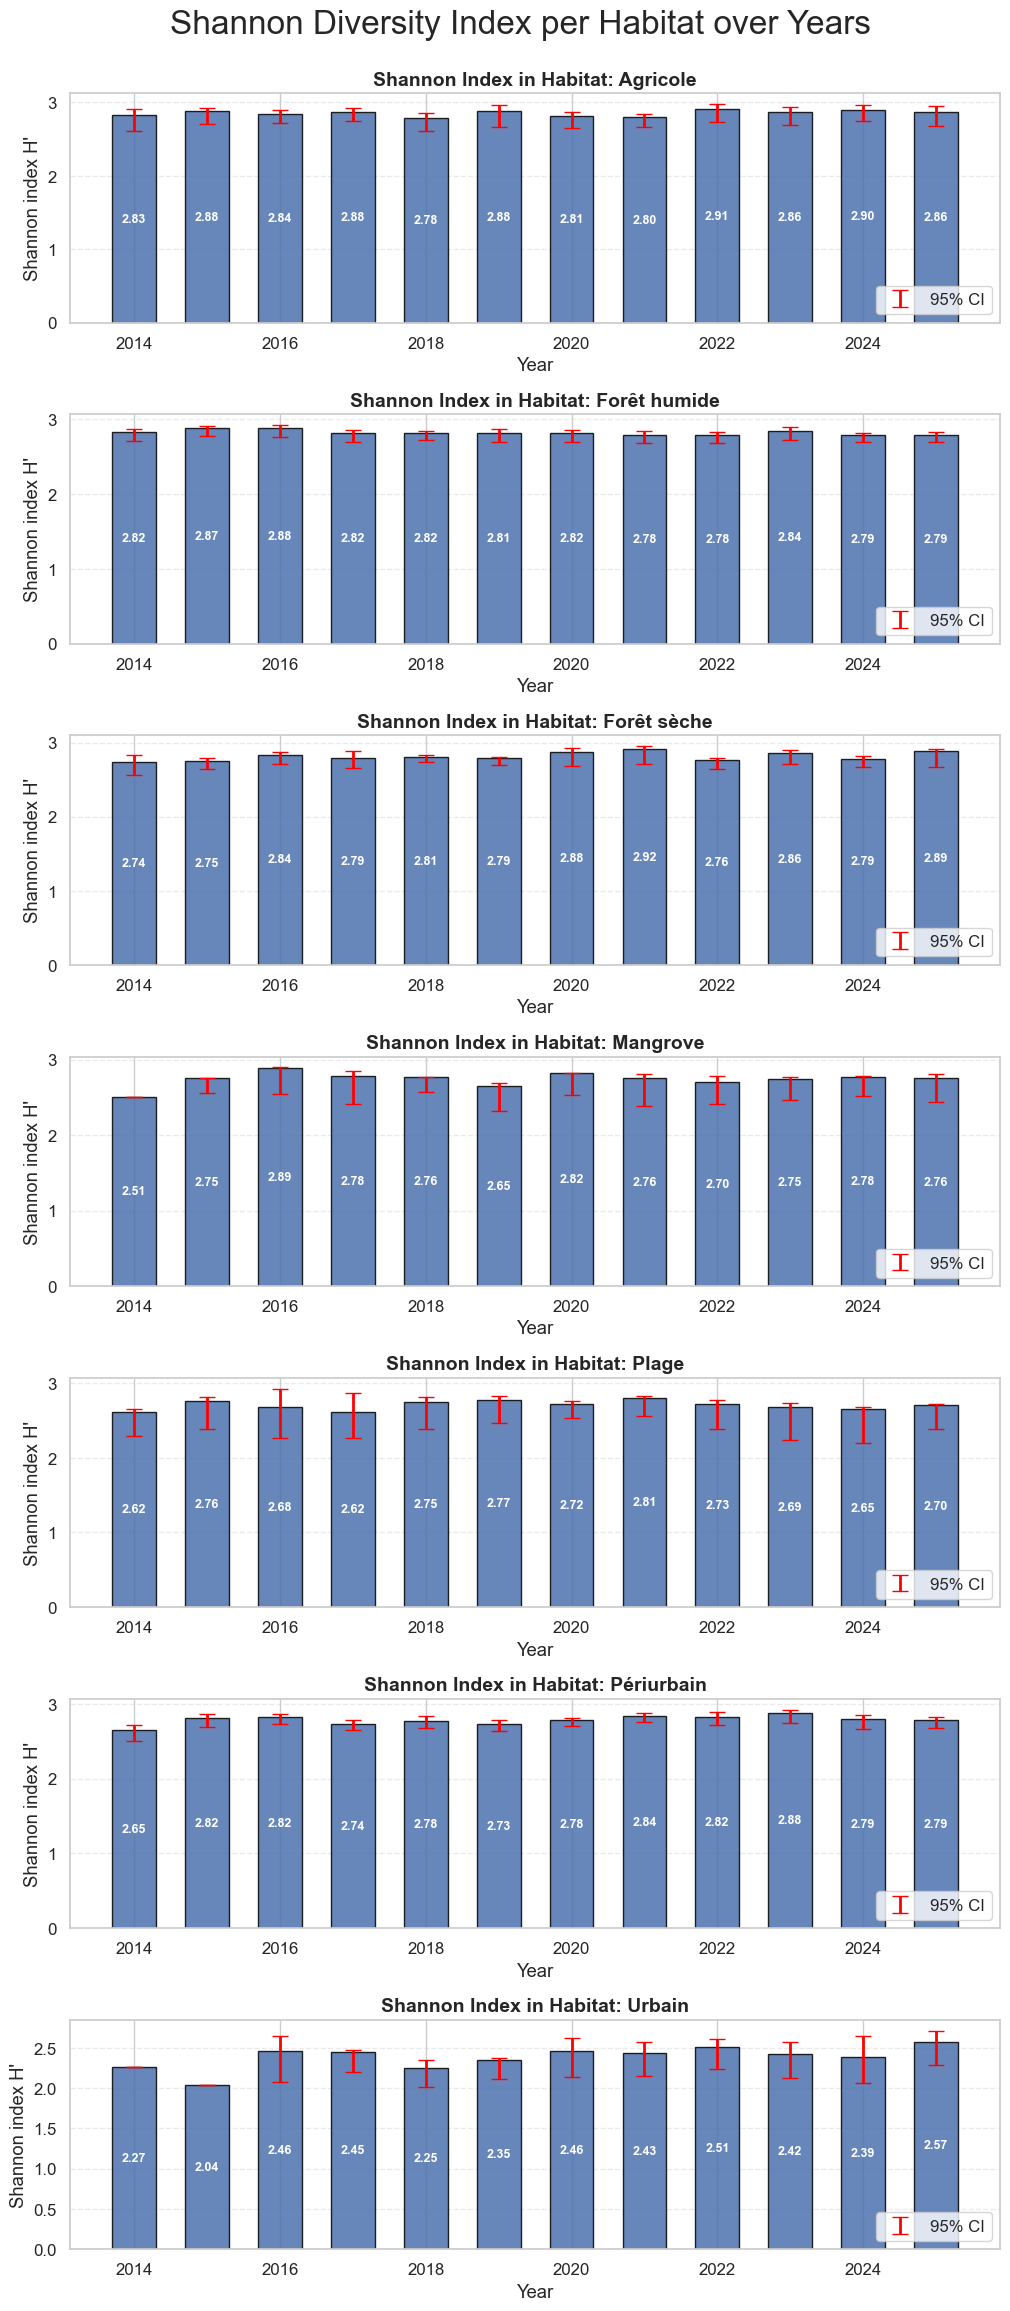

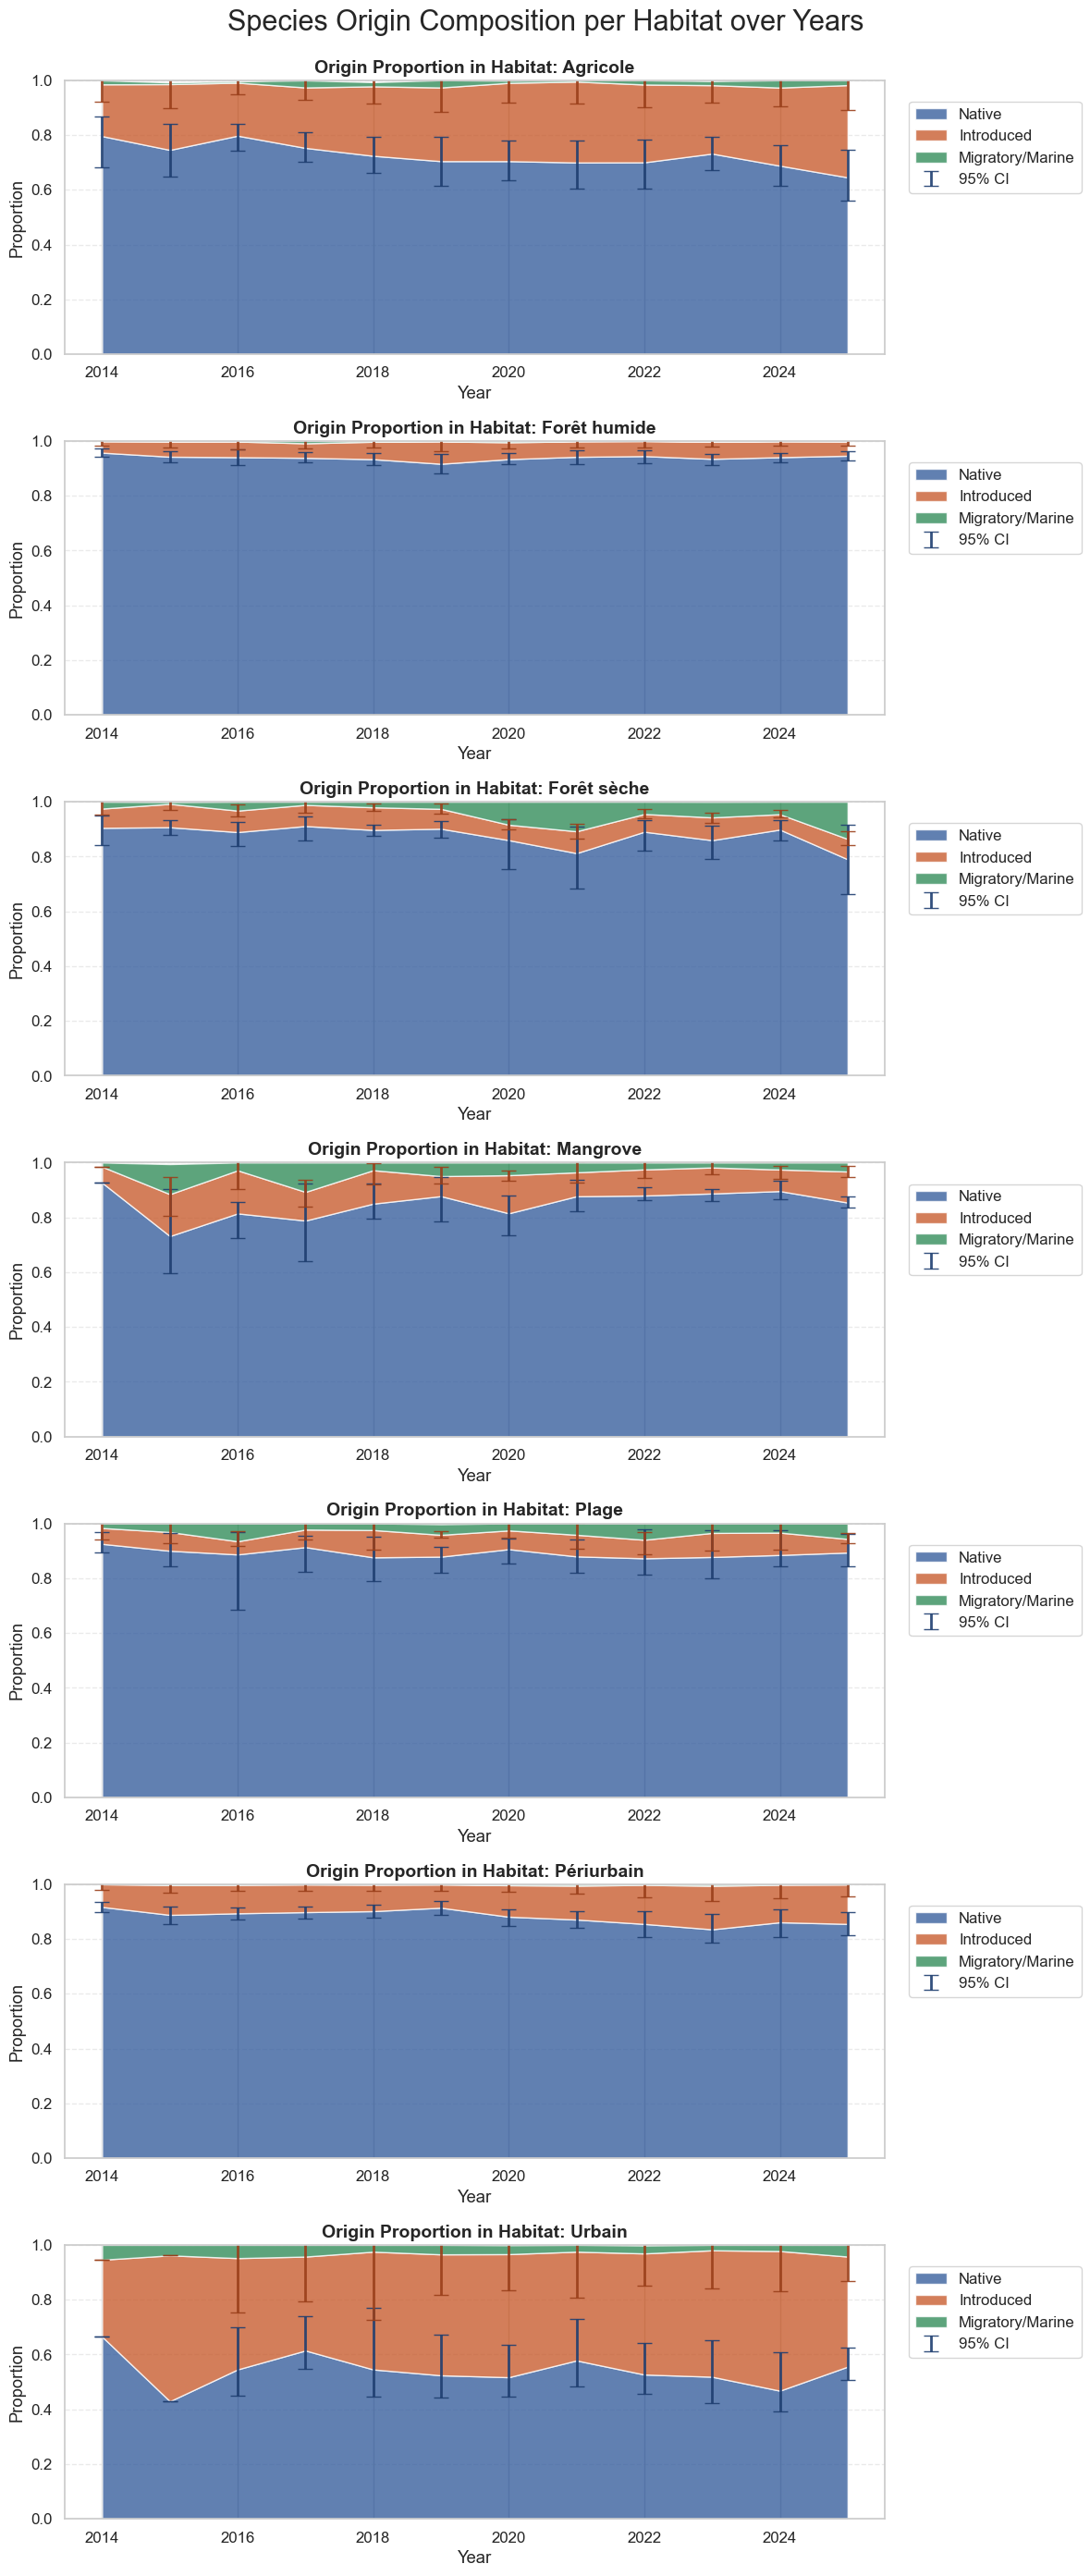

In [12]:
# Plotting Shannon diversity index and species origin proportions over years by habitat
habitats = indicator2_multi["Habitat"].unique()
n = len(habitats)

# Shannon Index
habitats = indicator2_multi["Habitat"].unique()
n_habitats = len(habitats)

fig, axes = plt.subplots(nrows=n_habitats, ncols=1, figsize=(12, 4 * n_habitats))
fig.suptitle("Shannon Diversity Index per Habitat over Years", fontsize=24, y=0.91)

for ax, habitat in zip(axes, habitats):
    g = indicator2_multi[indicator2_multi["Habitat"] == habitat].sort_values("year")
    bars = ax.bar(g["year"], g["Shannon_obs"], color="#4C72B0", alpha=0.85, width=0.6, edgecolor="black")
    ax.errorbar(g["year"], g["Shannon_obs"], yerr=[g["Shannon_obs"] - g["Shannon_low"], g["Shannon_high"] - g["Shannon_obs"]], fmt="none", ecolor="red", elinewidth=2, capsize=6, label="95% CI")
    for bar, value in zip(bars, g["Shannon_obs"]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2, f"{value:.2f}", ha="center", va="center", fontsize=9, fontweight="bold", color="white")
    ax.set_title(f"Shannon Index in Habitat: {habitat}", fontsize=14, fontweight="bold")
    ax.set_ylabel("Shannon index H'")
    ax.set_xlabel("Year")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc="lower right", frameon=True)

plt.xlabel("Year")
plt.subplots_adjust(hspace=0.4)
plt.savefig("figures/multi_year_shannon_index_by_habitat.jpeg", dpi=300, bbox_inches="tight")
plt.show()

# Origin Proportions (error bars on boundaries instead of mid)
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))
fig.suptitle("Species Origin Composition per Habitat over Years", fontsize=22, y=0.995)

for ax, habitat in zip(axes, habitats):
    g = indicator2_multi[indicator2_multi["Habitat"] == habitat].sort_values("year")
    ax.stackplot(g["year"], g["Native"], g["Introduced"], g["Migratory_Marine"], labels=["Native", "Introduced", "Migratory/Marine"], colors=["#345C9C", "#C75A2B", "#2F8B57"], alpha=0.78)
    native_boundary = g["Native"]
    introduced_boundary = g["Native"] + g["Introduced"]
    migratory_boundary = g["Native"] + g["Introduced"] + g["Migratory_Marine"]
    ax.errorbar( g["year"], native_boundary, yerr=[g["Native"] - g["Native_low"], g["Native_high"] - g["Native"]], fmt="none", ecolor="#1E3E70", elinewidth=2, capsize=6, label="95% CI", alpha=0.9)
    ax.errorbar(g["year"], introduced_boundary, yerr=[g["Introduced"] - g["Introduced_low"], g["Introduced_high"] - g["Introduced"]], fmt="none", ecolor="#9A3F1A", elinewidth=2, capsize=6, alpha=0.9)
    # CI on Migratory/Marin irrelevant (not enough data and space at the top of the plot)
    # ax.errorbar(g["year"], migratory_boundary, yerr=[g["Migratory_Marine"] - g["Migratory_low"], g["Migratory_high"] - g["Migratory_Marine"]], fmt="none", ecolor="#1F653C", elinewidth=2, capsize=6, alpha=0.9)
    ax.set_title(f"Origin Proportion in Habitat: {habitat}", fontsize=14, fontweight="bold")
    ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.set_xlabel("Year")
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 0.95))
    
plt.tight_layout()
plt.savefig("figures/multi_year_origin_proportions_per_habitat.jpeg", dpi=300, bbox_inches="tight")
plt.show()

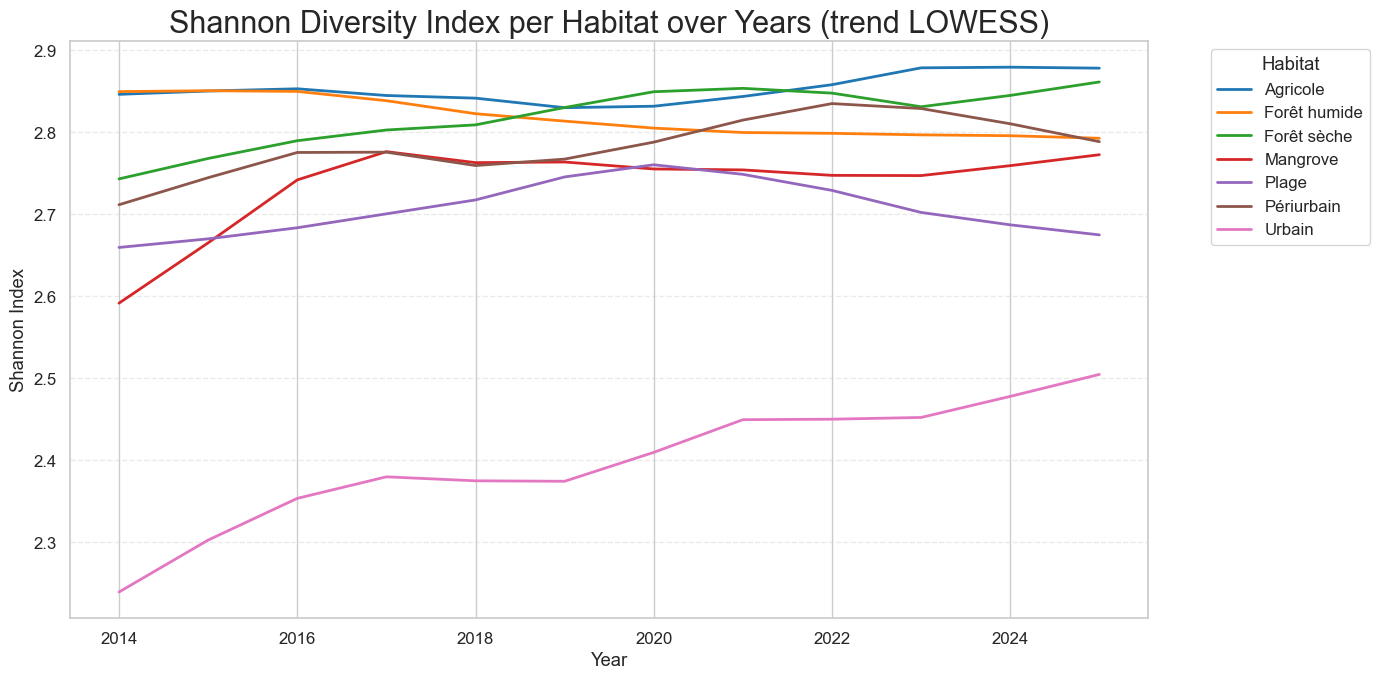

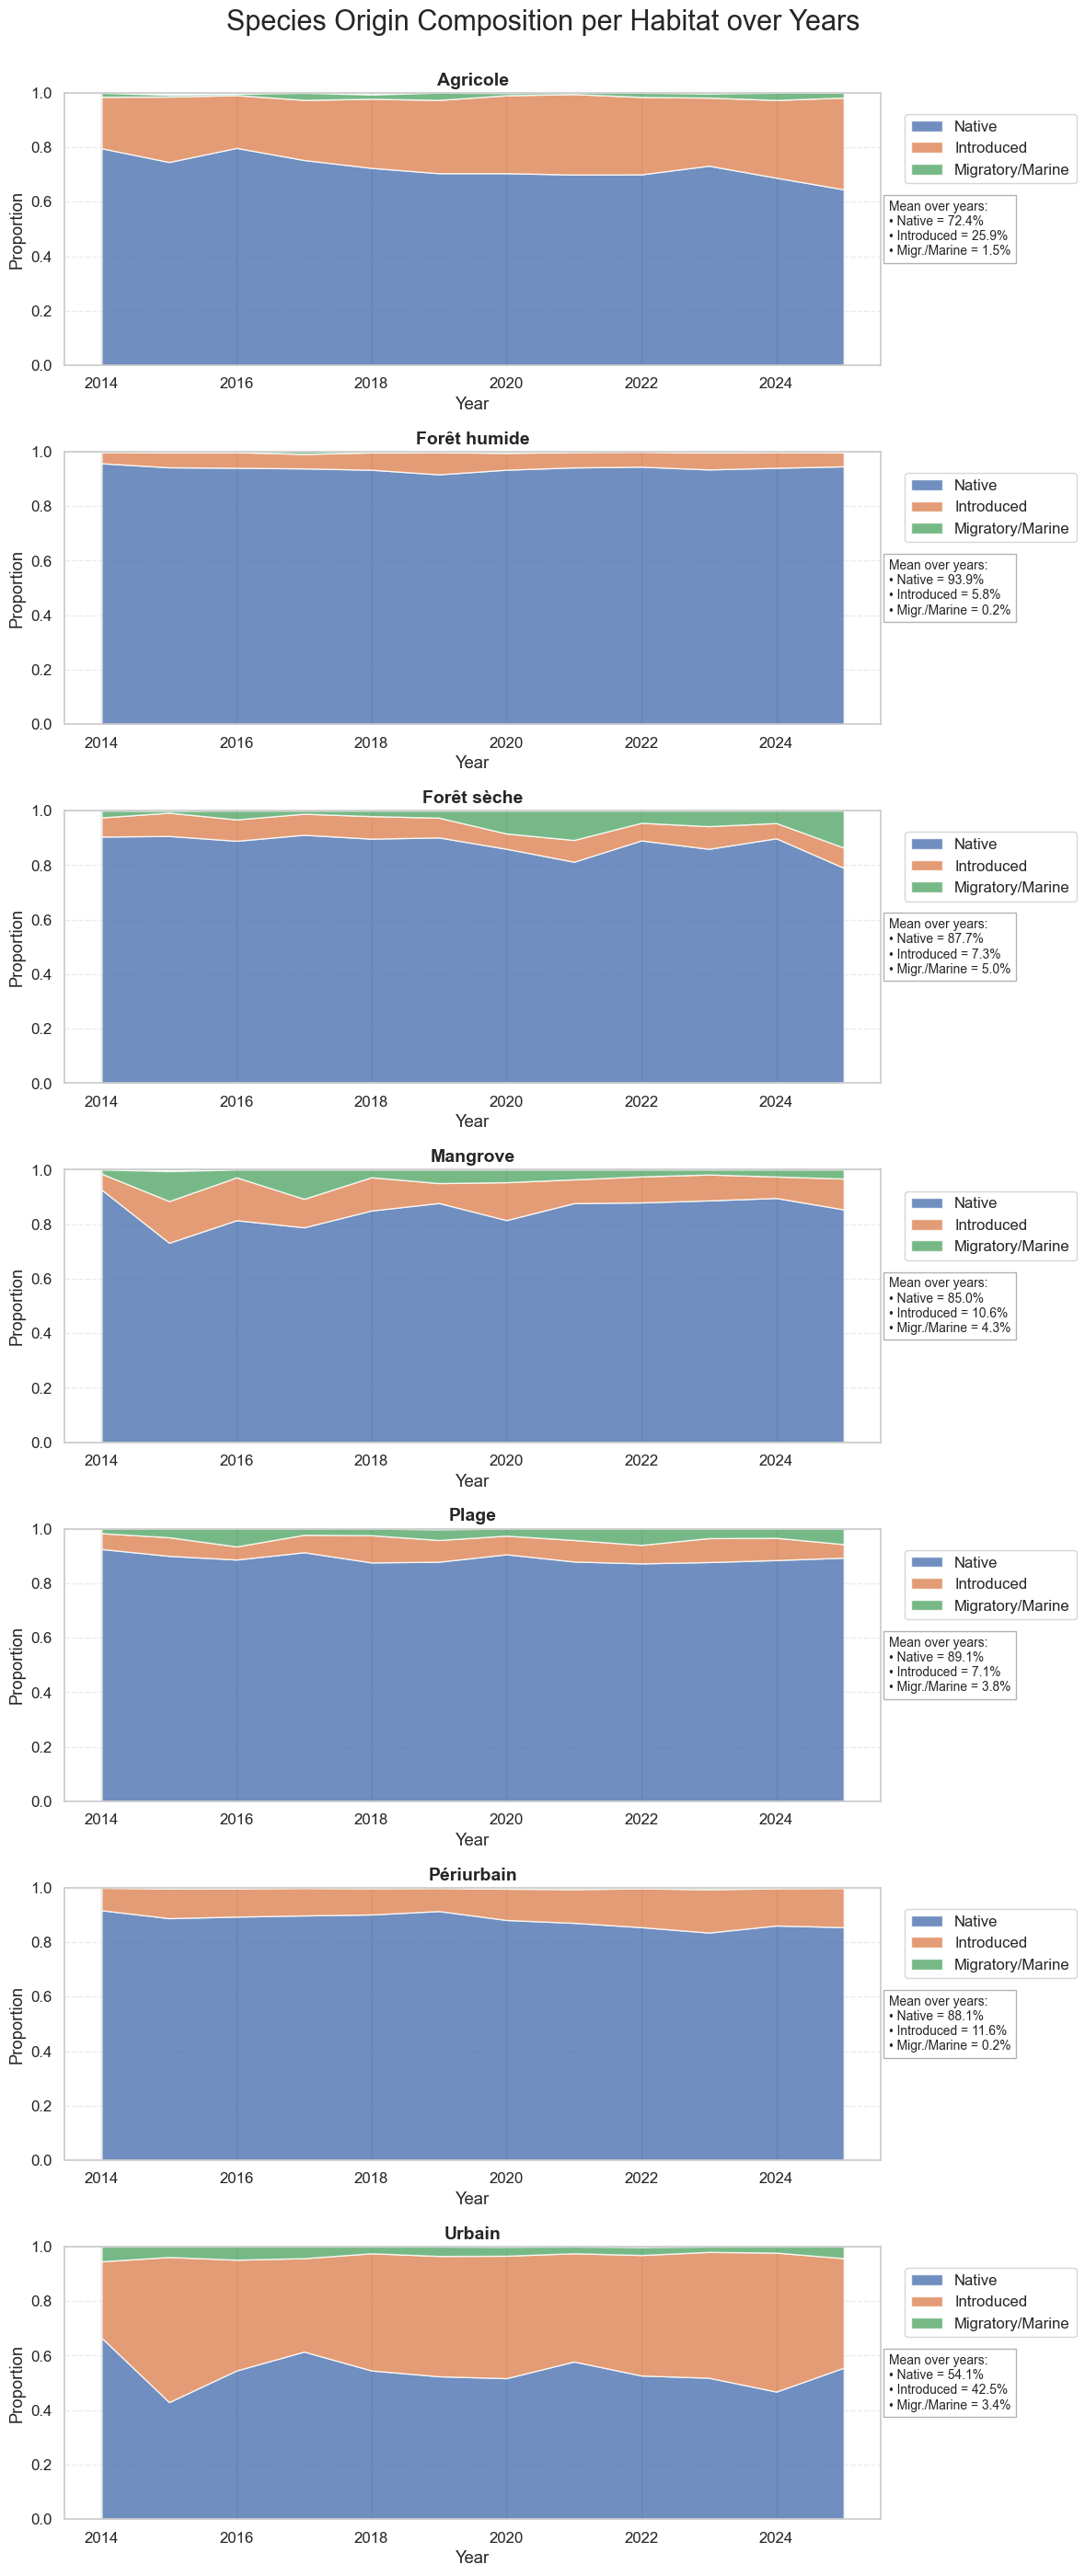

In [13]:
# Trend plots for Indicator 2

# Shannon index
habitats = indicator2_multi["Habitat"].unique()
n = len(habitats)
colors = sns.color_palette("tab10", n_colors=len(habitats))

plt.figure(figsize=(14, 7))
plt.title("Shannon Diversity Index per Habitat over Years (trend LOWESS)", fontsize=22)

for habitat, col in zip(habitats, colors):
    g = indicator2_multi[indicator2_multi["Habitat"] == habitat].sort_values("year")
    trend = lowess(g["Shannon_obs"], g["year"], frac=0.5)
    plt.plot(trend[:, 0], trend[:, 1], color=col, linewidth=2, linestyle="-", label=f"{habitat}")
plt.xlabel("Year")
plt.ylabel("Shannon Index")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Habitat", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("figures/trends_shannon_index.jpeg")
plt.show()

# Origin proportions
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))
fig.suptitle("Species Origin Composition per Habitat over Years", fontsize=22, y=1)

for ax, habitat in zip(axes, habitats):
    g = indicator2_multi[indicator2_multi["Habitat"] == habitat].sort_values("year")
    # Stackplot
    ax.stackplot(g["year"], g["Native"], g["Introduced"], g["Migratory_Marine"], labels=["Native", "Introduced", "Migratory/Marine"], colors=["#4C72B0", "#DD8452", "#55A868"], alpha=0.8)
    native_mean = g["Native"].mean()
    introduced_mean = g["Introduced"].mean()
    migratory_mean = g["Migratory_Marine"].mean()
    ax.text(1.01, 0.5, f"Mean over years:\n• Native = {native_mean*100:.1f}%\n• Introduced = {introduced_mean*100:.1f}%\n• Migr./Marine = {migratory_mean*100:.1f}%", transform=ax.transAxes, va="center", fontsize=10, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.6))
    ax.set_title(habitat, fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(bbox_to_anchor=(1.02, 0.95))

plt.xlabel("Year")
plt.tight_layout()
plt.savefig("figures/trends_origin_proportions_per_habitat.jpeg")
plt.show()

# Indicator 3: Sampling Effort (Unique Transects Visited and Visit Intensity)

The third indicator evaluates the sampling effort through two complementary metrics: the number of unique transects surveyed each year and the intensity of visits per transect. This indicator is essential because biodiversity estimates (richness, abundance, or community composition) are meaningful only if the underlying sampling effort is consistent. Variations in the number of sites visited or in survey frequency can produce artificial trends that mimic ecological changes, while in reality they may simply reflect differences in observer effort. By explicitly tracking sampling effort, we ensure that increases or decreases in species observations are interpreted correctly and not confounded with uneven fieldwork. This also allows us to verify the spatial representativeness of the monitoring program and to detect potential gaps. Ultimately, this indicator strengthens the reliability of the conclusions drawn from Indicators 1 and 2, and provides valuable feedback to improve future monitoring strategies.

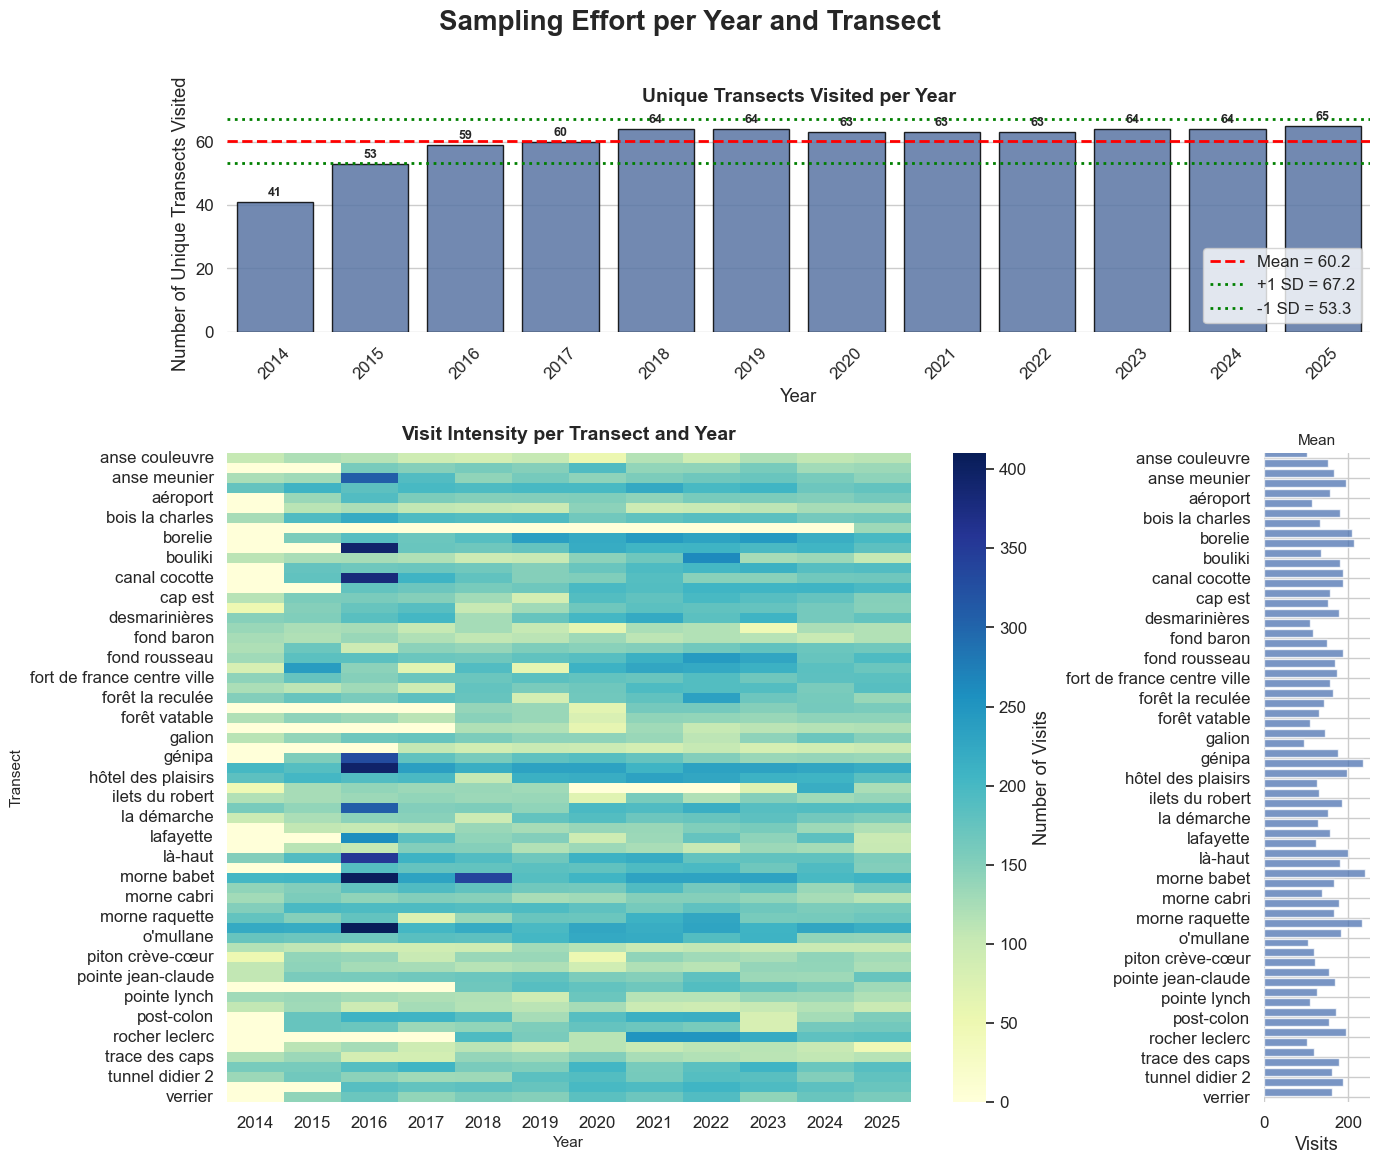

In [16]:
# Compute metrics
transects_per_year = df_observations.groupby("year")["Transect"].nunique().reset_index(name="Unique_transects")
mean_unique = transects_per_year["Unique_transects"].mean()
std_unique = transects_per_year["Unique_transects"].std()

visits_per_transect_year = df_observations.groupby(["Transect", "year"]).size().reset_index(name="Visits")
pivot_heatmap = visits_per_transect_year.pivot_table(index="Transect", columns="year", values="Visits", fill_value=0)
mean_visits, median_visits = pivot_heatmap.replace(0, np.nan).mean(axis=1), pivot_heatmap.replace(0, np.nan).median(axis=1)
pivot_heatmap_with_stats = pivot_heatmap.assign(Mean=mean_visits, Median=median_visits)

# Create figure layout
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 3], width_ratios=[8, 1])
ax_bar = fig.add_subplot(gs[0, :]) 
ax_hm = fig.add_subplot(gs[1, 0])        
ax_stats = fig.add_subplot(gs[1, 1], sharey=ax_hm)
fig.suptitle("Sampling Effort per Year and Transect", fontsize=20, fontweight="bold", y=0.97)

# Unique transects per year
sns.barplot(data=transects_per_year, x="year", y="Unique_transects", color="#4C72B0", ax=ax_bar, alpha=0.85, edgecolor="black")
for i, val in enumerate(transects_per_year["Unique_transects"]):
    ax_bar.text(i, val + 1, f"{val:.0f}", ha="center", va="bottom", fontsize=9, fontweight="bold")
ax_bar.axhline(mean_unique, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_unique:.1f}")
ax_bar.axhline(mean_unique + std_unique, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean_unique + std_unique:.1f}')
ax_bar.axhline(mean_unique - std_unique, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean_unique - std_unique:.1f}')
ax_bar.set_title("Unique Transects Visited per Year", fontsize=14, fontweight="bold", pad=10)
ax_bar.set_ylabel("Number of Unique Transects Visited")
ax_bar.set_xlabel("Year")
ax_bar.legend(loc="upper right", frameon=True)
ax_bar.tick_params(axis="x", rotation=45)
ax_bar.legend(loc="lower right", frameon=True)

# Visit intensity
sns.heatmap(pivot_heatmap_with_stats.iloc[:, :-2], cmap="YlGnBu", annot=False, cbar_kws={"label": "Number of Visits"}, ax=ax_hm)
ax_hm.set_title("Visit Intensity per Transect and Year", fontsize=14, fontweight="bold", pad=10)
ax_hm.set_xlabel("Year", fontsize=11)
ax_hm.set_ylabel("Transect", fontsize=11)

# Mean and median visits
ax_stats.barh(pivot_heatmap_with_stats.index, pivot_heatmap_with_stats["Mean"], color="#4C72B0", alpha=0.75, label="Mean")
ax_stats.set_title("Mean", fontsize=11)
ax_stats.set_xlabel("Visits")
sns.despine(left=True, bottom=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figures/sampling_effort_per_year_and_transect.jpeg")
plt.show()

### Indicator 3 trends

Indicator 3 measures sampling effort, using two metrics:
 1) the number of unique transects visited per year, and
 2) the visit intensity per transect (number of visits per year).

These values are not estimates derived from a statistical model or from a sample used to infer a population parameter.
They are directly observed operational data, determined by the survey protocol (how many transects were scheduled and how many were actually visited). There is no sampling variability: visiting 42 transects is a factual event, not a stochastic outcome. Therefore, computing confidence intervals would not make sense, confidence intervals quantify uncertainty around an estimate, not around fixed logistics decisions or recorded effort.

In other words, for Indicator 3 we are not estimating a quantity, we are simply reporting how much effort was deployed. Confidence intervals are meaningful when the goal is to infer an underlying ecological state (species richness, diversity index, community composition), but not when reporting survey effort.


/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_7277/2601650033.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(frameon=True, loc="upper left")


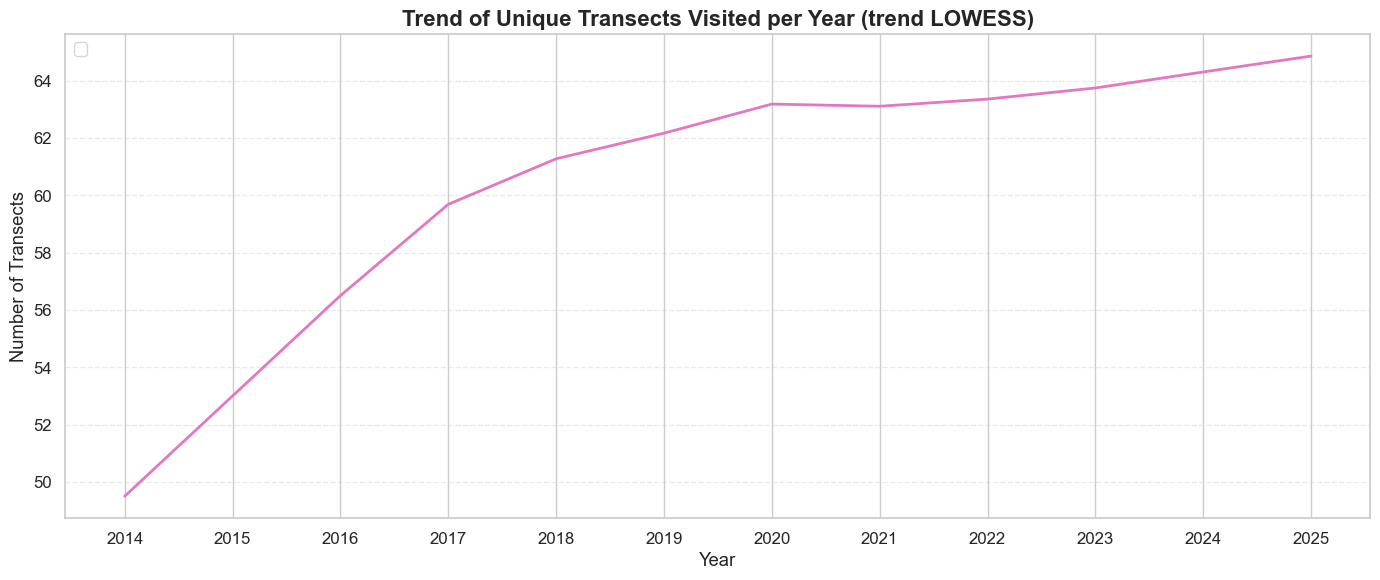

In [17]:
# Compute metrics
transects_per_year = df_observations.groupby("year")["Transect"].nunique().reset_index(name="Unique_transects")
mean_unique = transects_per_year["Unique_transects"].mean()
std_unique = transects_per_year["Unique_transects"].std()

# Plot unique transects per year trend
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(111)
trend = lowess(transects_per_year["Unique_transects"], transects_per_year["year"], frac=0.5)
ax1.plot(trend[:, 0], trend[:, 1], color=col, linewidth=2, linestyle="-")

ax1.set_title("Trend of Unique Transects Visited per Year (trend LOWESS)", fontsize=16, fontweight="bold")
ax1.set_ylabel("Number of Transects")
ax1.set_xlabel("Year")
ax1.grid(axis="y", linestyle="--", alpha=0.4)
ax1.set_xticks(transects_per_year["year"])
ax1.legend(frameon=True, loc="upper left")

plt.tight_layout()
plt.savefig("figures/trends_sampling_effort.jpeg", dpi=300, bbox_inches="tight")
plt.show()